In [1]:
from MieSppForce import  green_func, frenel, dipoles, force
from MieSppForce.directivity import get_directivity
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

In [4]:
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

R = 295/2
#148
dist = 2
#d=60
a_angle = np.pi/4
angle = 25*np.pi/180
point = [0,0,dist+R]
z0 = point[2]
wls=np.linspace(600,1200,100)
phase = -np.pi/2

k0 = lambda wl: 2*np.pi/wl/1e-9
omega = lambda wl: 2*np.pi*c_const/wl/1e-9

STOP = 45

In [5]:
F_x = np.empty((len(wls), 8))
F_y = np.empty_like(F_x)
F_z = np.empty_like(F_x)

Fy_pxmz = np.empty(len(wls))
Fy_pzmx = np.empty(len(wls))
Fx_pymz = np.empty(len(wls))
Fx_pzmy = np.empty(len(wls))

F_x_pm_mp_1  = np.empty(len(wls))
F_x_pm_mp_2 = np.empty(len(wls))
F_y_pm_mp_1 = np.empty(len(wls))
F_y_pm_mp_2 = np.empty(len(wls))

P,M = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)

def AlphaE(R, eps_Si):
    return lambda wl: dipoles.alpha_v2(wl, R, eps_Si)[0]
def AlphaH(R, eps_Si):
    return lambda wl: dipoles.alpha_v2(wl, R, eps_Si)[1]

AlphaEE = AlphaE(R, eps_Si)
AlphaHH = AlphaH(R, eps_Si)

dxGExz = np.empty(len(wls), dtype=complex)
dxGHxz = np.empty_like(dxGExz)
dyGEyz = np.empty_like(dxGExz)
dyGHyz = np.empty_like(dxGExz) 


dxrotGHyz= np.empty(len(wls), dtype=complex)
dxrotGHzy= np.empty(len(wls), dtype=complex)
dyrotGHxz= np.empty(len(wls), dtype=complex)
dyrotGHzx= np.empty(len(wls), dtype=complex)

for i in tqdm(range(len(wls))):
    f =  force.F(wls[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    dyrotGE, dyrotGH = green_func.dy_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    dxrotGE, dxrotGH = green_func.dx_rot_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    dxGE,dxGH = green_func.dx_green_E_H(wls[i], point[2], eps_Au, STOP)
    dyGE,dyGH = green_func.dy_green_E_H(wls[i], point[2], eps_Au, STOP)
    
    dxGExz[i] = dxGE[0,2]
    dxGHxz[i] = dxGH[0,2]
    dyGEyz[i] = dyGE[1,2]
    dyGHyz[i] = dyGH[1,2]
    
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m
    
    dxrotGHyz[i], dxrotGHzy[i] = dxrotGH[1,2], dxrotGH[2,1]
    dyrotGHxz[i], dyrotGHzx[i] = dyrotGH[0,2], dyrotGH[2,0]
    
   
    Fx_pymz_exact = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2])  + k0(wls[i])**3/(12 * np.pi )) * np.real(p[1].conj()*m[2])

    Fx_pzmy_exact = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1]) - k0(wls[i])**3/(12 * np.pi)) * np.real(p[2].conj() * m[1])
    
    F_x_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[1,2]) ) * np.real(p[1].conj()*m[2])
    
    F_x_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dxrotGH[2,1])) * np.real(p[2].conj() * m[1])
        
    Fy_pxmz_exact = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])  - k0(wls[i])**3/(12 * np.pi )) * np.real(p[0].conj()*m[2])

    Fy_pzmx_exact = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) + k0(wls[i])**3/(12 * np.pi)) * np.real(p[2].conj() * m[0])
    
    F_y_pm_mp_1_i = - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[0,2])) * np.real(p[0].conj()*m[2])
    
    F_y_pm_mp_2_i =  - omega(wls[i]) * mu0_const * (np.imag(dyrotGH[2,0]) ) * np.real(p[2].conj() * m[0])

    Fy_pxmz[i] = Fy_pxmz_exact
    Fy_pzmx[i] = Fy_pzmx_exact
    Fx_pymz[i] = Fx_pymz_exact
    Fx_pzmy[i] = Fx_pzmy_exact
    
    F_x_pm_mp_1[i] = F_x_pm_mp_1_i
    F_x_pm_mp_2[i] = F_x_pm_mp_2_i
    F_y_pm_mp_1[i] = F_y_pm_mp_1_i
    F_y_pm_mp_2[i] = F_y_pm_mp_2_i
        

100%|██████████| 100/100 [04:14<00:00,  2.55s/it]


In [2]:
PHI = np.linspace(0, 2*np.pi, 100)

directivity = np.empty((len(PHI), len(wls)))
for wl_idx, wl in enumerate(wls):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P[wl_idx,:], M[wl_idx,:], eps_Au)
        directivity[angle_idx, wl_idx] = D(PHI[angle_idx])

NameError: name 'wls' is not defined

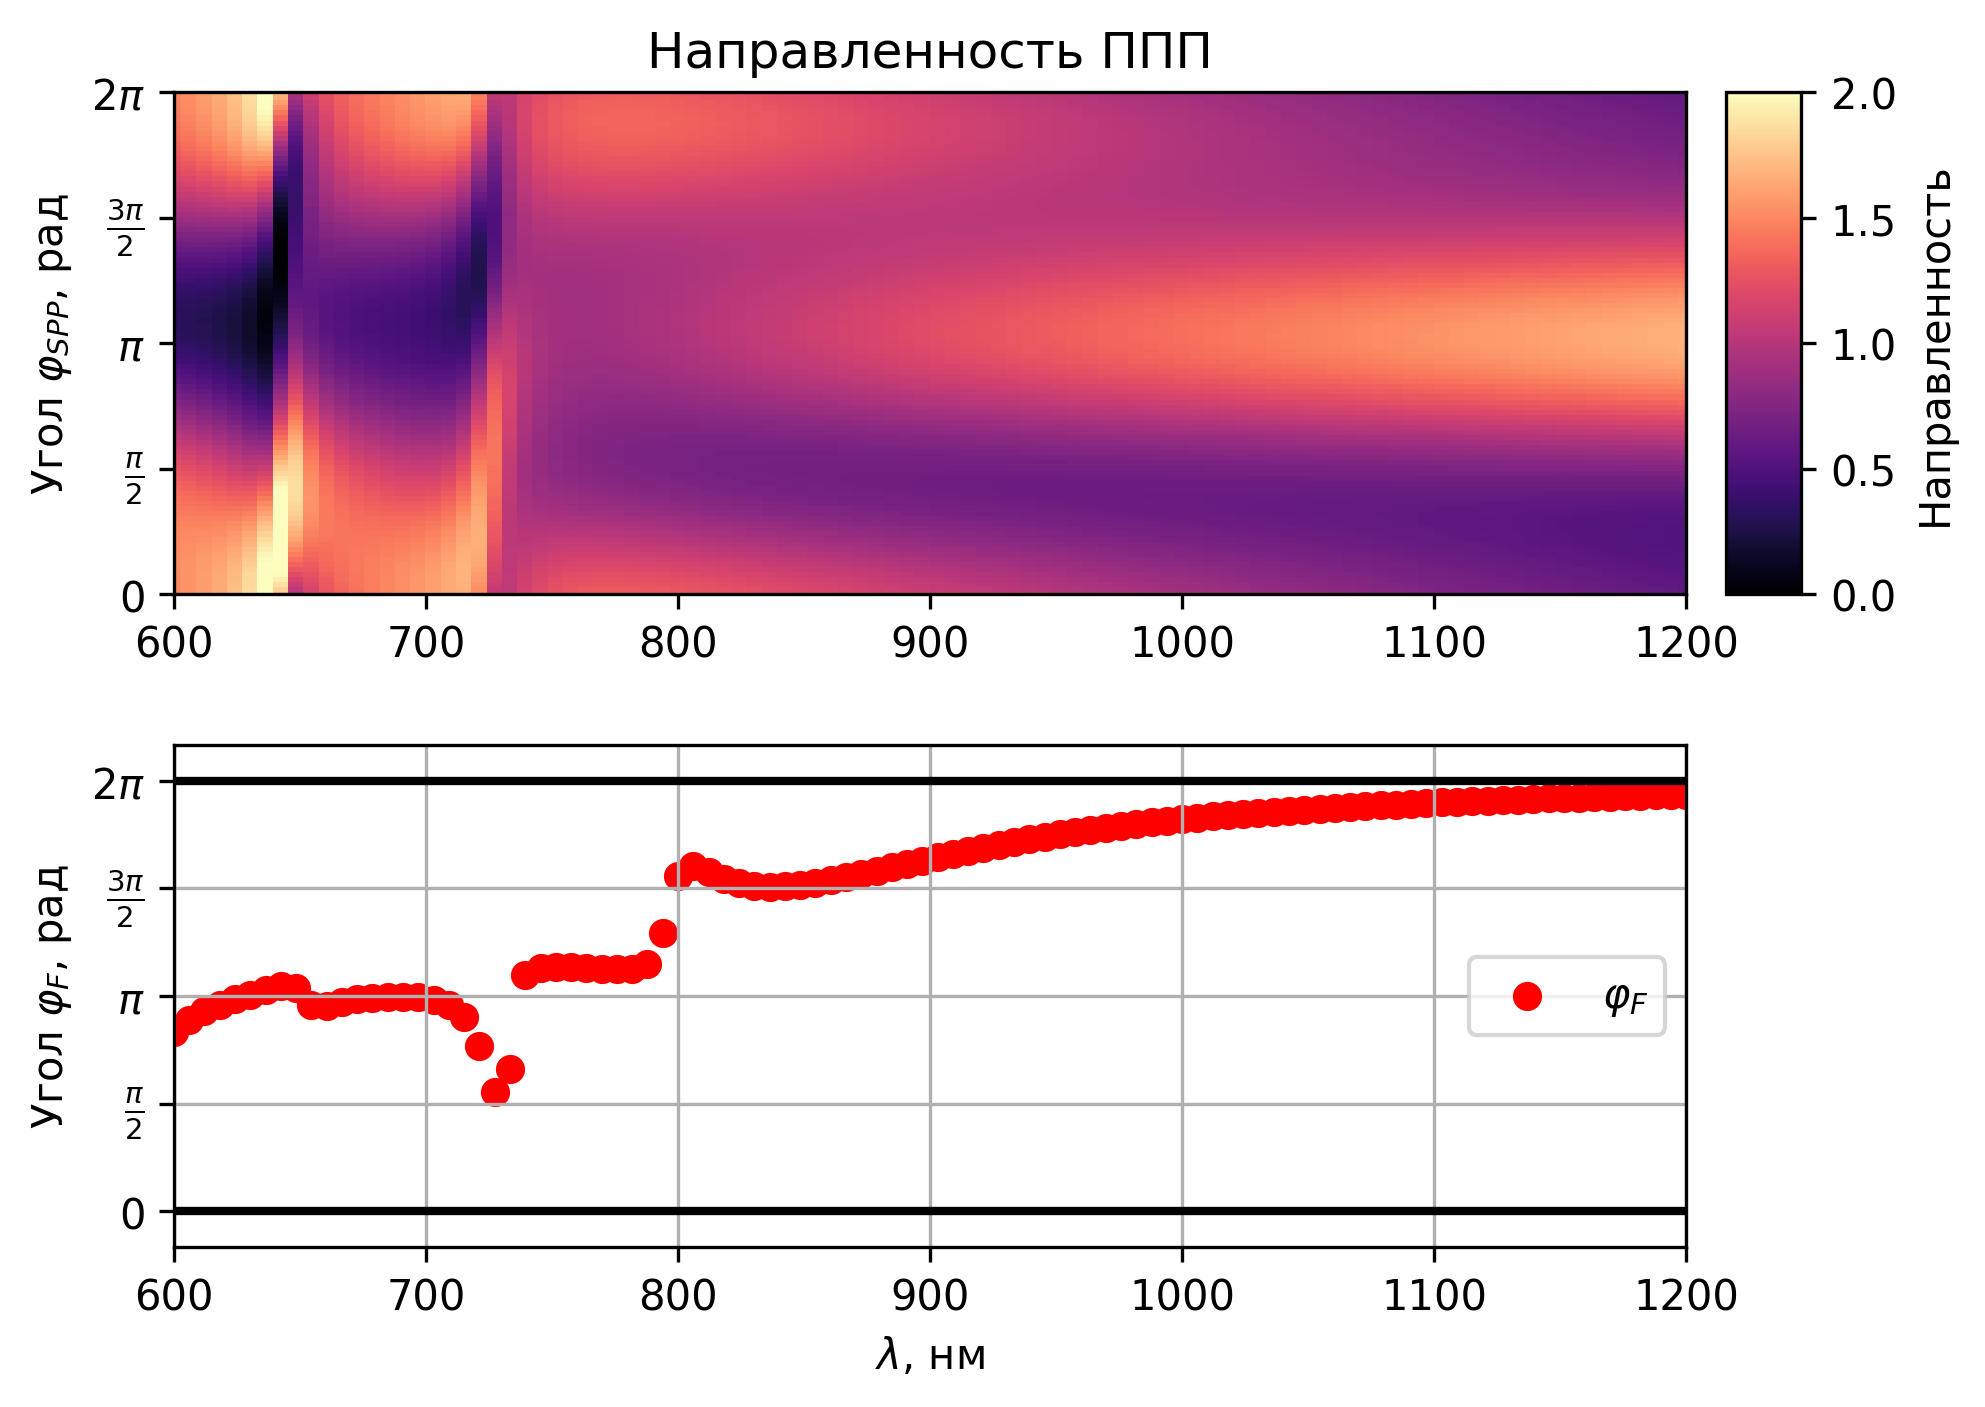

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(wls, PHI, directivity, cmap='magma', vmax=2, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
# y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(0, 2*np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc= np.arctan2(F_y[:, 0], F_x[:, 0] - F_x[:, 1]-F_x[:,4])

angles_only_fpp = np.arctan2(F_y[:,5], F_x[:, 5])
#angles_no_sc= np.unwrap(angles_no_sc)

# Отрисовка угла
angles_no_sc = (angles_no_sc + 2 * np.pi) % (2 * np.pi)

ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
ax_bottom.axhline(2*np.pi, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(wls, angles_no_sc, label=r'$\varphi_F$', color='r', linewidth=1)
ax_bottom.set_ylim(-1*np.pi/6, 13*np.pi/6)
ax_bottom.set_xlim(wls[0], wls[-1])
ax_bottom.set_xlabel('$\\lambda$, нм')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
plt.savefig(f'spp_vs_f_nosc_from_wl_z0_{point[2]}_R_{R}_phase_{round(phase,2)}_beta_{round(a_angle,2)}.png', dpi=300)



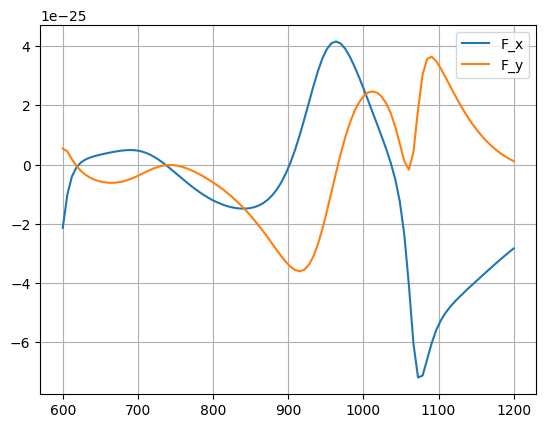

In [119]:
plt.plot(wls, F_x[:,3]+F_x[:,6]+F_x[:,7], label='F_x')
plt.plot(wls, F_y[:,3]+F_y[:,6]+F_y[:,7], label='F_y')
plt.grid()
plt.legend()

In [120]:

fmax_wls = 0
for i in range(len(wls)):
    f0 = force.F(wls[i], 1, [0,0,0], R, eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_wls:
        fmax_wls = f0

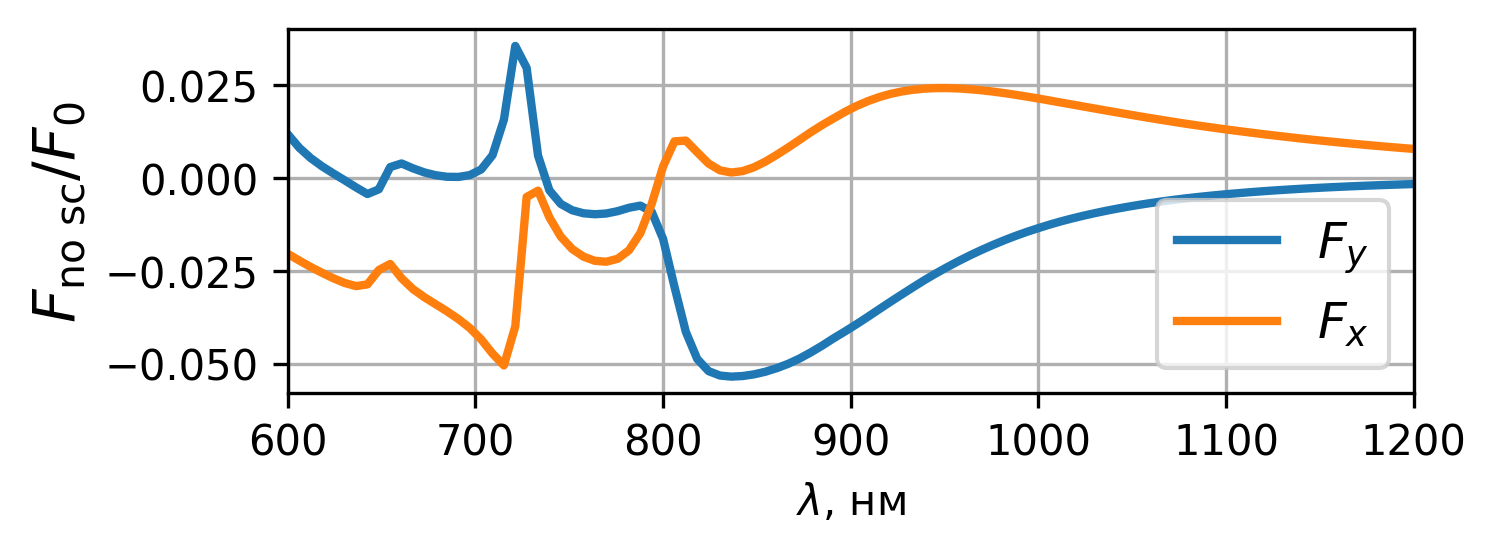

In [135]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2), sharex=True, dpi=300)


ax1.plot(wls, F_y[:,0]/fmax_wls, label='$F_y$', linewidth=2, color='#1f77b4')
ax1.plot(wls, (F_x[:,0]-F_x[:,1]-F_x[:,4])/fmax_wls, label='$F_x$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F_{\\text{no sc}}/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f_no_sc_from_wl_z0_{point[2]}.pdf', dpi=300)
plt.show()




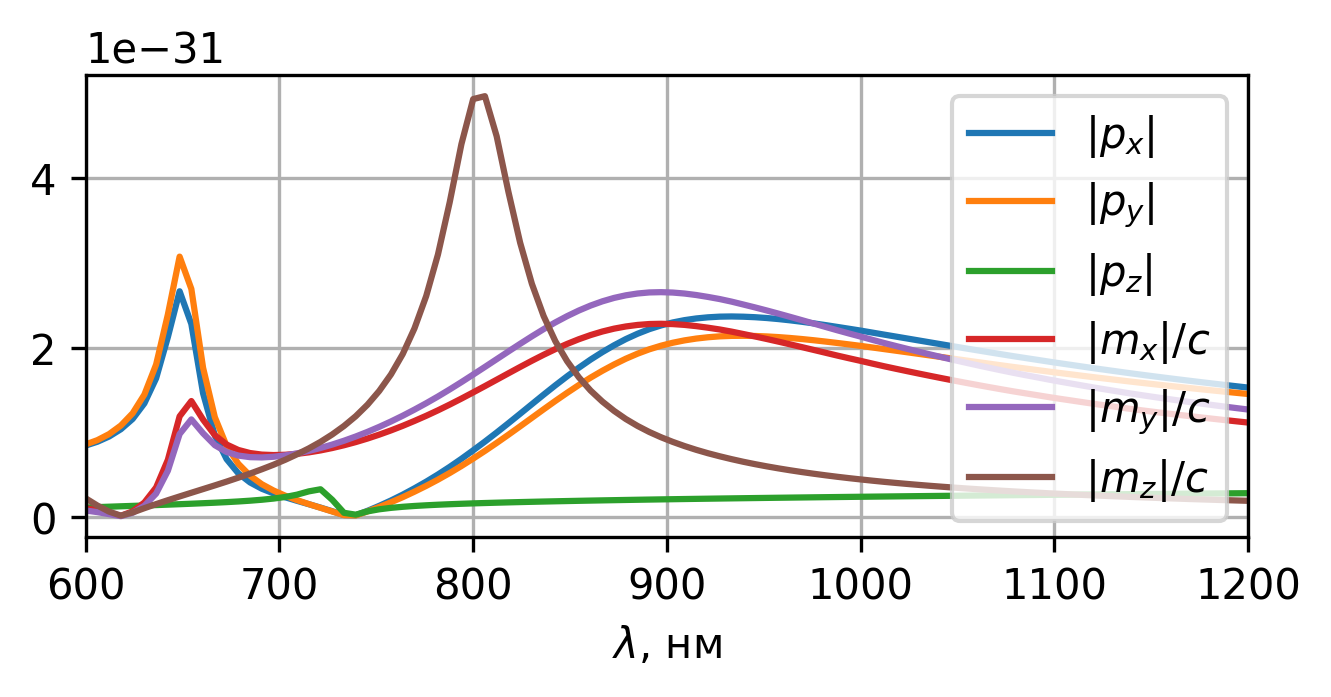

In [138]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, np.abs(P[:,0]), label='$|p_x|$')
plt.plot(wls, np.abs(P[:,1]), label='$|p_y|$')
plt.plot(wls, np.abs(P[:,2]), label='$|p_z|$')
plt.plot(wls, np.abs(M[:,0])/c_const, label='$|m_x|/c$')
plt.plot(wls, np.abs(M[:,1])/c_const, label='$|m_y|/c$')
plt.plot(wls, np.abs(M[:,2])/c_const, label='$|m_z|/c$')
plt.legend(loc='upper right')
plt.grid()
plt.xlim(wls[0], wls[-1])

plt.xlabel('$\\lambda$, нм')
plt.savefig(f'dipoles_from_wl_z0_{point[2]}_R_{R}_phase_{round(phase,2)}_beta_{round(a_angle,2)}.pdf', dpi=300)


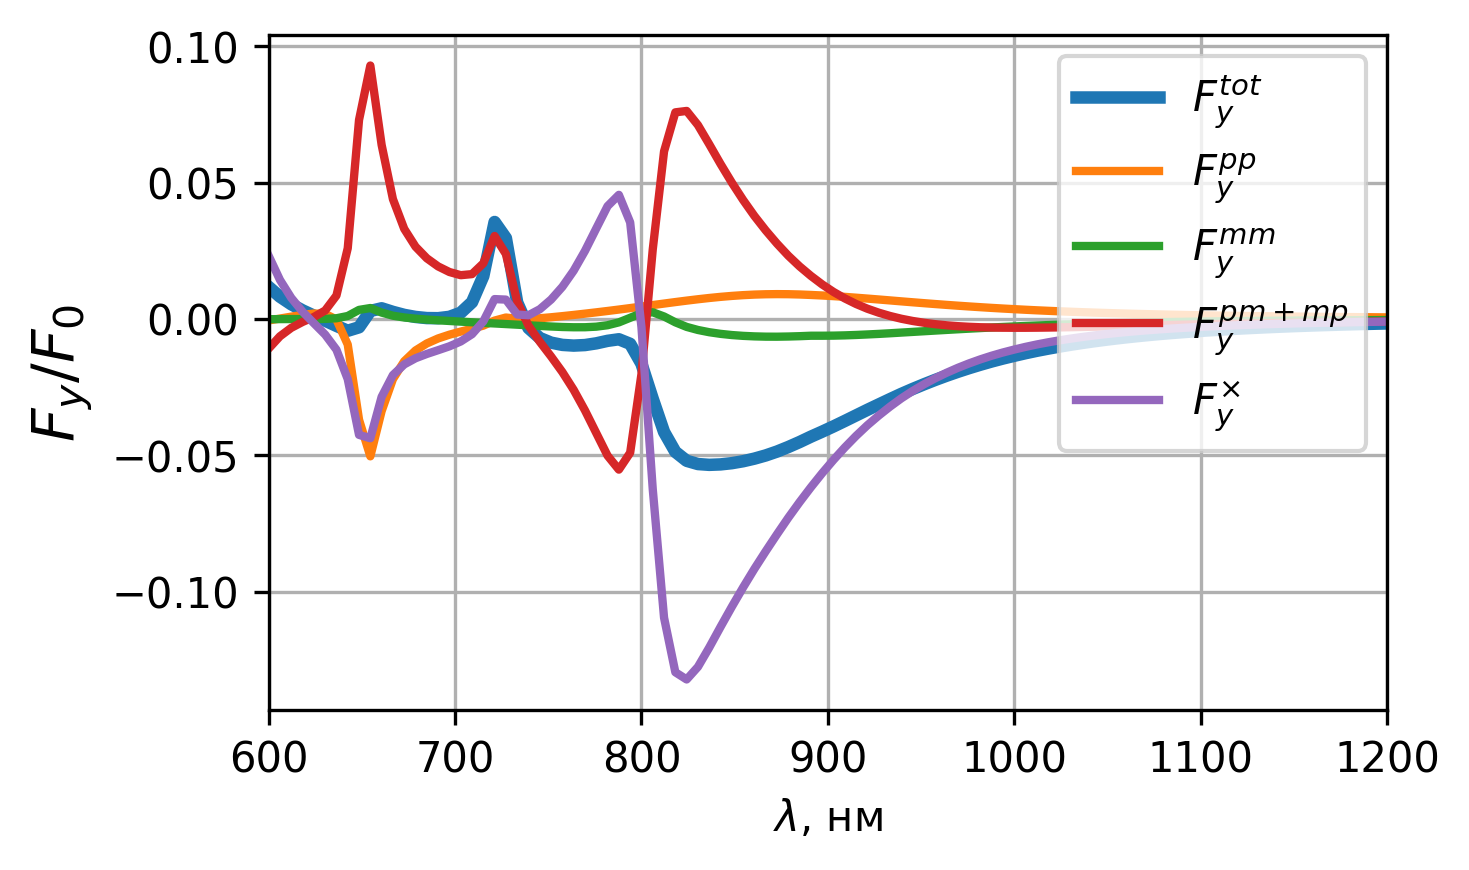

In [140]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(wls, F_y[:,0]/fmax_wls, label='$F_y^{tot}$', linewidth=3)
ax1.plot(wls, F_y[:,2]/fmax_wls, label='$F_y^{pp}$', linewidth=2)
ax1.plot(wls, F_y[:,5]/fmax_wls, label='$F_y^{mm}$', linewidth=2)
ax1.plot(wls, (F_y[:,6]+F_y[:,3])/fmax_wls, label='$F_y^{pm+mp}$', linewidth=2)
ax1.plot(wls, F_y[:,7]/fmax_wls, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_y/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
plt.savefig(f'f_y_no_sc_from_wl_z0_{point[2]}.png', dpi=300)
plt.show()




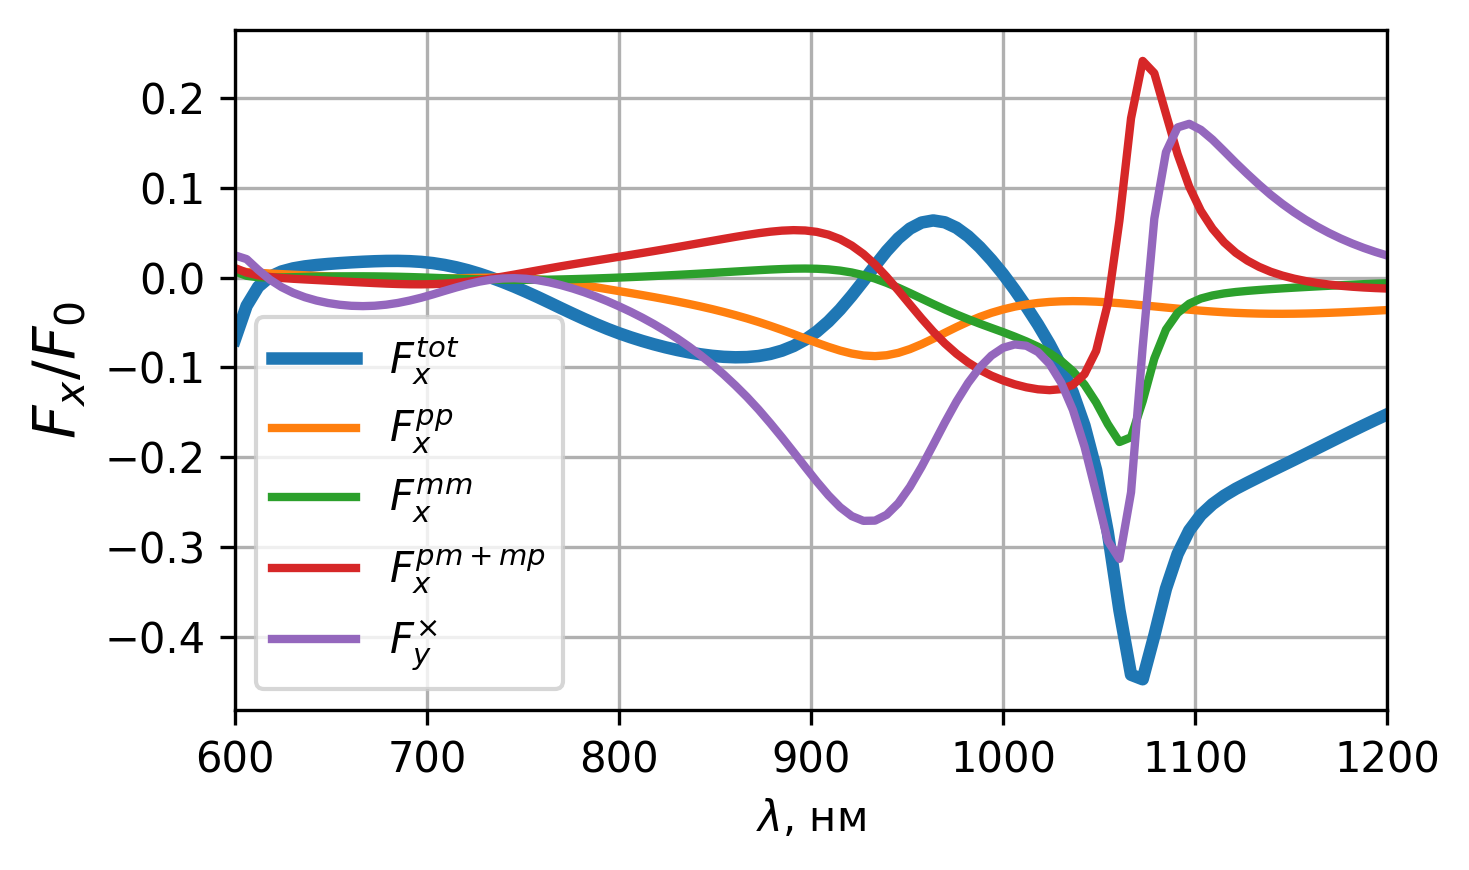

In [107]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(wls, (F_x[:,0]-F_x[:,1]-F_x[:,4])/fmax_wls, label='$F_x^{tot}$', linewidth=3)
ax1.plot(wls, F_x[:,2]/fmax_wls, label='$F_x^{pp}$', linewidth=2)
ax1.plot(wls, F_x[:,5]/fmax_wls, label='$F_x^{mm}$', linewidth=2)
ax1.plot(wls, (F_x[:,6]+F_x[:,3])/fmax_wls, label='$F_x^{pm+mp}$', linewidth=2)
ax1.plot(wls, F_y[:,7]/fmax_wls, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_x/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$\\lambda$, нм')

plt.xlim(wls[0], wls[-1])

plt.tight_layout()
#plt.savefig(f'f_x_no_sc_from_wl_z0_{point[2]}.png', dpi=300)
plt.show()


In [141]:
phiii = np.empty(len(wls))
for i in range(len(wls)):
    j = np.argmax(directivity[:,i])
    phiii[i] = PHI[j]


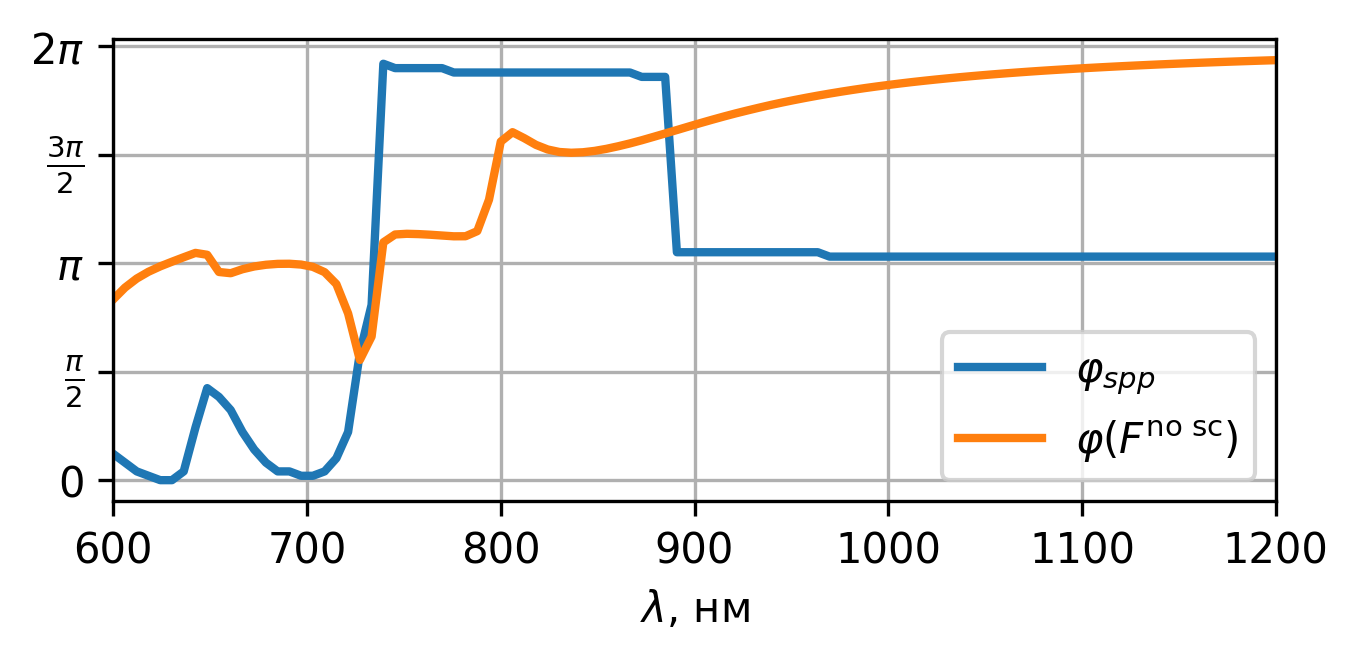

In [143]:
angles_no_sc= np.arctan2(F_y[:, 0], F_x[:, 0] - F_x[:, 1]-F_x[:,4])
angles_no_sc = (angles_no_sc + 2 * np.pi) % (2 * np.pi)

plt.figure(figsize=(5,2), dpi=300)
plt.plot(wls, phiii, label=r'$\varphi_{spp}$', lw=2)
plt.plot(wls, angles_no_sc, label=r'$\varphi (F^{\text{no sc}})$', lw=2)
plt.grid()
plt.legend(loc='lower right')
plt.yticks(y_ticks,y_ticklabels)

plt.xlim(wls[0], wls[-1])
plt.xlabel('$\\lambda$, нм')
plt.savefig(f'angles_from_wl_z0_{point[2]}.png', dpi=300)

In [16]:
sigma_sc = np.loadtxt("Dipoles_Analytical\sigma_tot.txt", skiprows=8, delimiter=',')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\borod\AppData\Local\Temp\ipykernel_7436\2075925555.py:1: SyntaxWarning: invalid escape sequence '\s'
  sigma_sc = np.loadtxt("Dipoles_Analytical\sigma_tot.txt", skiprows=8, delimiter=',')


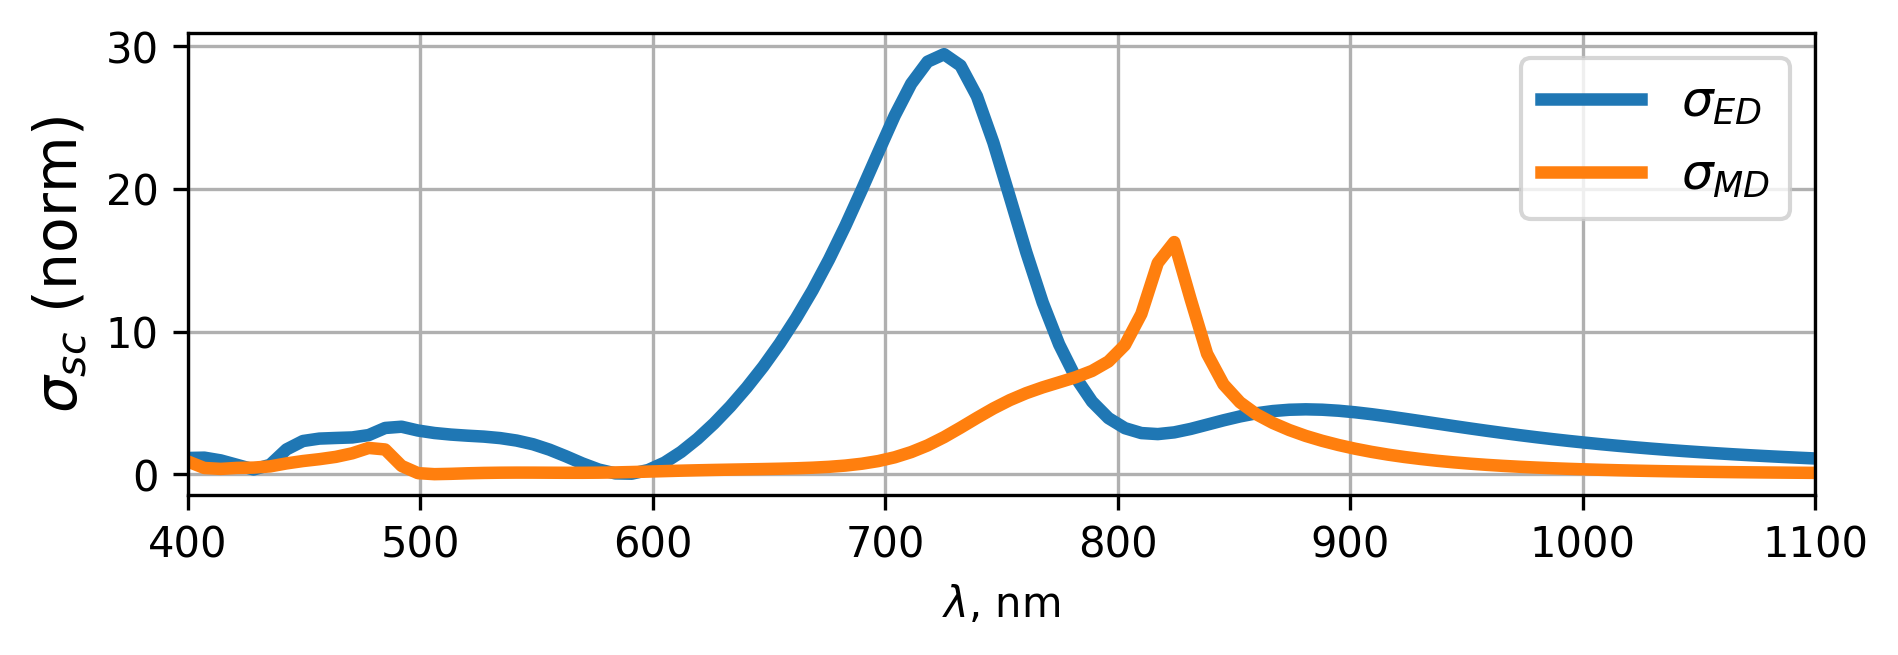

In [35]:
const_sigma_sc = k0(wls)**4/(6*np.pi*eps0_const**2)

ED = np.abs(P[:,0])**2+ np.abs(P[:,1])**2+np.abs(P[:,2])**2

MD = (np.abs(M[:,0])**2+ np.abs(M[:,1])**2+np.abs(M[:,2])**2)/c_const**2

sigma_ED = ED *const_sigma_sc
sigma_MD = MD * const_sigma_sc




fig, ax1 = plt.subplots(1, 1, figsize=(7, 2), dpi=300)

# Первый график: ED и MD

ax1.plot(wls, sigma_ED/(np.pi*(R*1e-9)**2), label='$\\sigma_{ED}$', lw=3)
ax1.plot(wls, sigma_MD/(np.pi*(R*1e-9)**2), label='$\\sigma_{MD}$', lw=3)


# ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1], label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4', ls='--')
# ax1.plot(sigma_sc[:, 0], sigma_sc[:, 2], label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e', ls='--')
ax1.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('$\\lambda$, nm')

plt.xlim(wls[0], wls[-1])

plt.savefig(f'sigma_sc_from_wl_z0_{point[2]}.pdf', dpi=300)


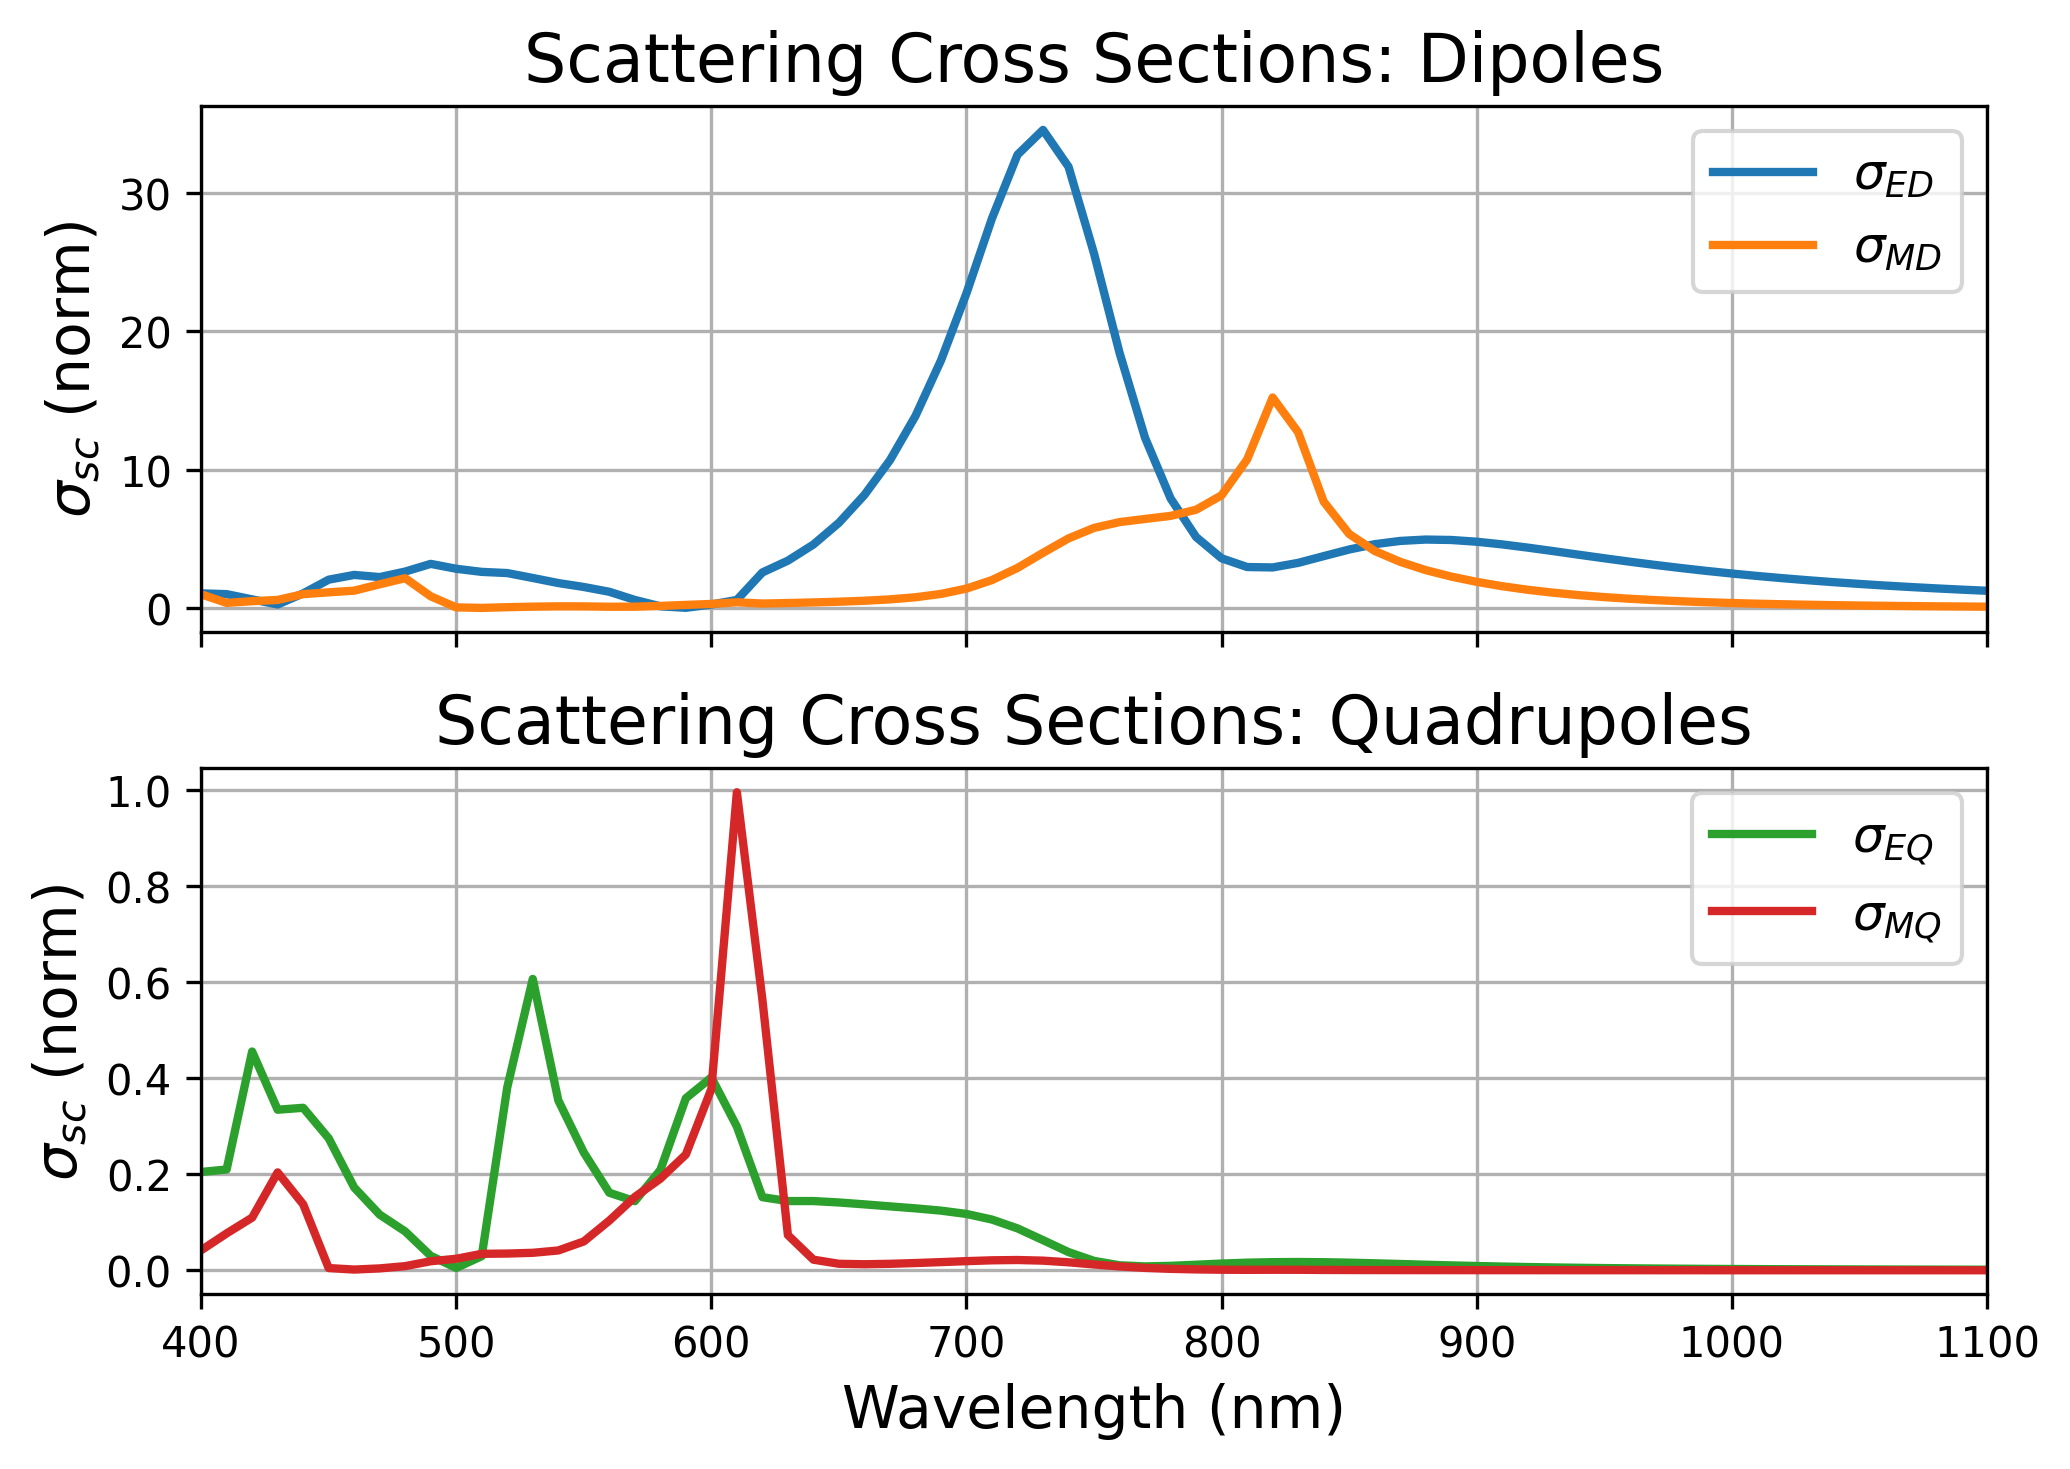

In [168]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1], label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4')
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 2], label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e')
ax1.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_title('Scattering Cross Sections: Dipoles', fontsize=16)

plt.xlim(sigma_sc[0, 0], sigma_sc[-1, 0])

# Второй график: EQ и MQ
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 3], label='$\\sigma_{EQ}$', linewidth=2, color='#2ca02c')
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 4], label='$\\sigma_{MQ}$', linewidth=2, color='#d62728')
ax2.set_xlabel('Wavelength (nm)', fontsize=14)
ax2.set_ylabel('$\\sigma_{sc}$ (norm)', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)
ax2.set_title('Scattering Cross Sections: Quadrupoles', fontsize=16)

plt.tight_layout()
plt.savefig('scattering_cross_sections_from_wl.pdf', dpi=300)
plt.show()


In [82]:
Rs = np.linspace(110, 140, 100)
wl = 800
STOP = 45
angle = 25*np.pi/180
dist = 55
a_angle = np.pi/4
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')
phase = -np.pi/2

F_x_from_R = np.empty((len(Rs), 8))
F_y_from_R = np.empty_like(F_x_from_R)
F_z_from_R = np.empty_like(F_x_from_R)

P_from_R,M_from_R = np.empty((len(Rs),3), dtype=complex),np.empty((len(Rs),3), dtype=complex)


for i in tqdm(range(len(Rs))):
    point = [0,0,dist]
    f =  force.F(wl, eps_Au, point, Rs[i], eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x_from_R[i,:] = f[0]
    F_y_from_R[i,:] = f[1]
    F_z_from_R[i,:] = f[2]
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, Rs[i], eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P_from_R[i,:],M_from_R[i,:]=p,m
    
    

PHI = np.linspace(-np.pi, np.pi, 100)

directivityR = np.empty((len(PHI), len(Rs)))
for R_idx, R_i in enumerate(Rs):
    for angle_idx in range(len(PHI)):
        D = get_directivity(wl, P_from_R[R_idx,:], M_from_R[R_idx,:], eps_Au)
        directivityR[angle_idx, R_idx] = D(PHI[angle_idx])

        

100%|██████████| 100/100 [00:02<00:00, 40.34it/s]


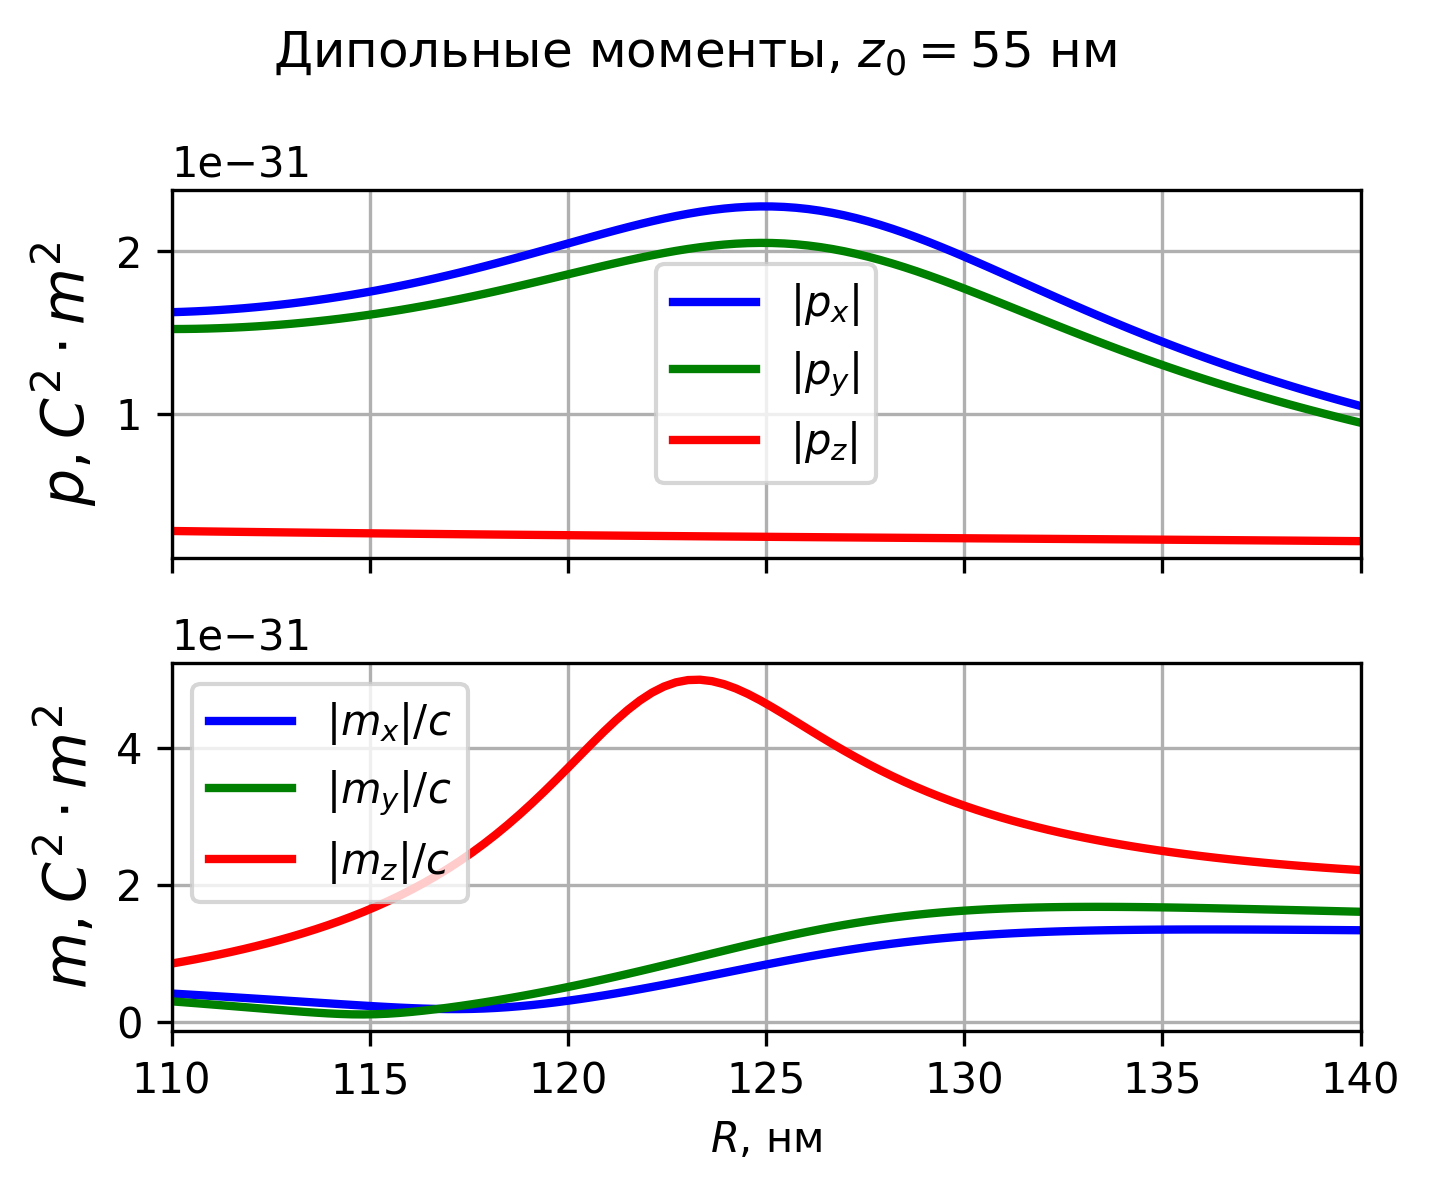

In [84]:
fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(5, 4), sharex=True, dpi=300)

ax1.plot(Rs, np.abs(P_from_R[:,0]), label='|$p_x|$', color='blue', lw=2)
ax1.plot(Rs, np.abs(P_from_R[:,1]), label='$|p_y|$', color='green', lw=2)   
ax1.plot(Rs, np.abs(P_from_R[:,2]), label='$|p_z|$', color='red', lw=2)

ax2.plot(Rs, np.abs(M_from_R[:,0])/c_const, label='$|m_x|/c$', color='blue', lw=2)
ax2.plot(Rs, np.abs(M_from_R[:,1])/c_const, label='$|m_y|/c$', color='green', lw=2)   
ax2.plot(Rs, np.abs(M_from_R[:,2])/c_const, label='$|m_z|/c$', color='red', lw=2)


ax1.set_ylabel('$p, C^2 \\cdot m^2$', fontsize=14)
ax1.grid(True)
ax1.legend()
plt.suptitle(f'Дипольные моменты, $z_0=${dist} нм')


ax2.set_ylabel('$m, C^2 \\cdot m^2$', fontsize=14)
ax2.grid(True)
ax2.legend()
ax2.set_xlabel('$R$, нм')

plt.xlim(Rs[0], Rs[-1])


plt.tight_layout()
plt.savefig(f'p_m_from_R_z0_{dist}_wl_{wl}_a_{round(a_angle,2)}_phase_{round(phase,2)}.pdf', dpi=300)
plt.show()

In [17]:
sigma_sc = np.loadtxt('comsol data\\sigma-r.txt', skiprows=8, delimiter=',')
force_comsol = np.loadtxt('comsol data\\force-r.txt', skiprows=8, delimiter=',')

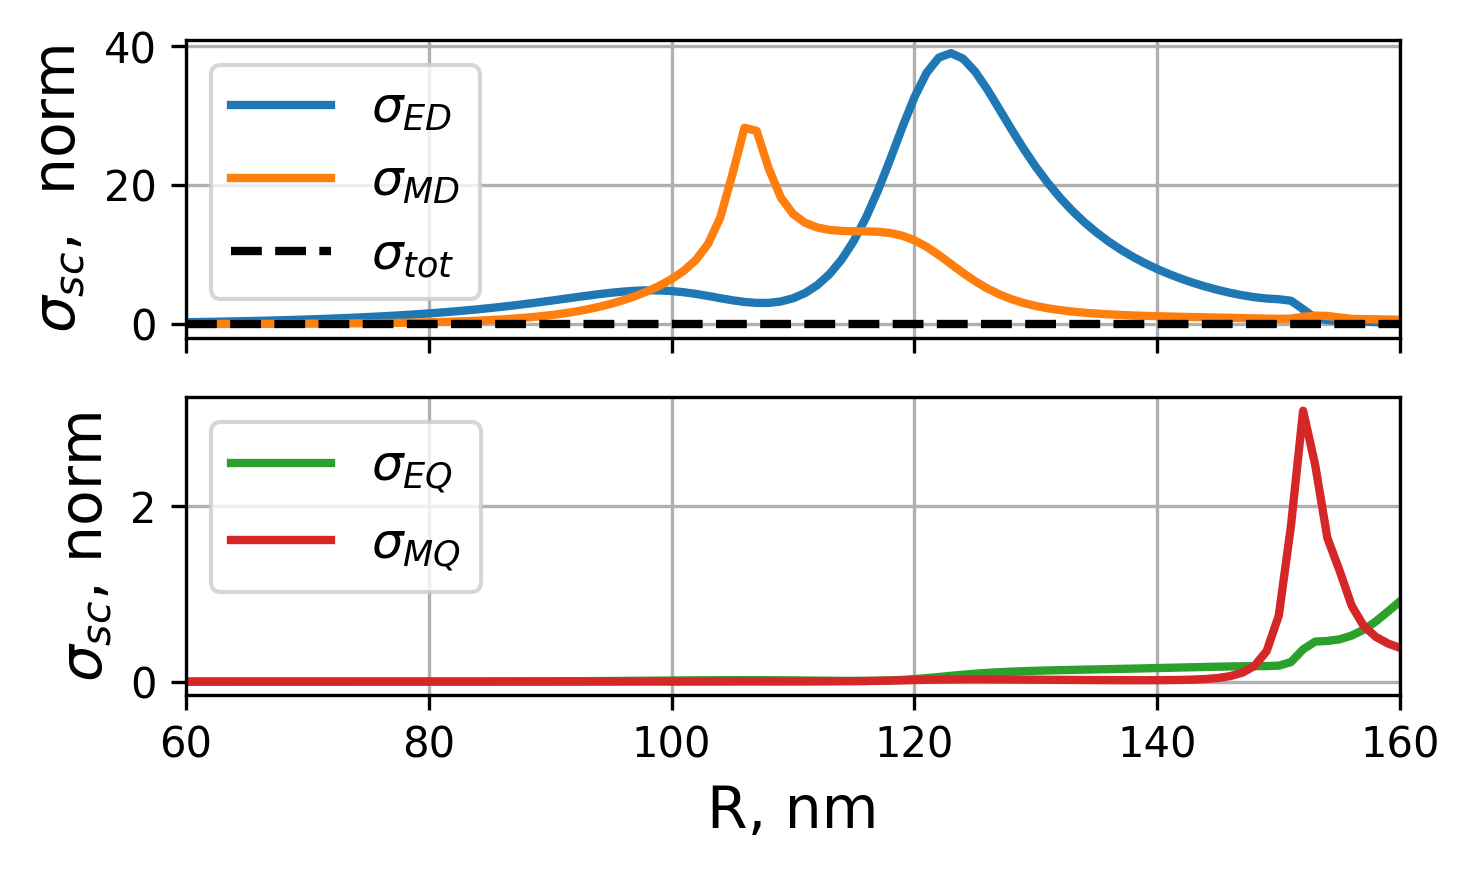

In [ ]:

fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(5, 3), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(sigma_sc[:, 0], sigma_sc[:, 1]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{ED}$', linewidth=2, color='#1f77b4')
ax1.plot(sigma_sc[:, 0], 2*sigma_sc[:, 2]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{MD}$', linewidth=2, color='#ff7f0e')
ax1.plot(sigma_sc[:, 0], (sigma_sc[:, 1]+2*sigma_sc[:, 2])/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{tot}$', linewidth=2, color='black', ls='--')
ax1.set_ylabel('$\\sigma_{sc}$,  norm', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
# ax1.set_xlabel('R, нм')

plt.xlim(sigma_sc[0, 0], sigma_sc[-1, 0])

# Второй график: EQ и MQ
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 3]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{EQ}$', linewidth=2, color='#2ca02c')
ax2.plot(sigma_sc[:, 0], sigma_sc[:, 4]/(np.pi *(sigma_sc[:, 0]*1e-9)**2), label='$\\sigma_{MQ}$', linewidth=2, color='#d62728')
ax2.set_xlabel('R, nm', fontsize=14)
ax2.set_ylabel('$\\sigma_{sc}$, norm', fontsize=14)
ax2.grid(True)
ax2.legend(fontsize=12)

plt.tight_layout()
#plt.savefig('scattering_cross_sections_from_R.png', dpi=300)
plt.show()


In [73]:
fmax = 0
for i in range(len(Rs)):
    f0 = force.F(wl, 1, [0,0,0], Rs[i], eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax:
        fmax = f0
  

NameError: name 'force_comsol' is not defined

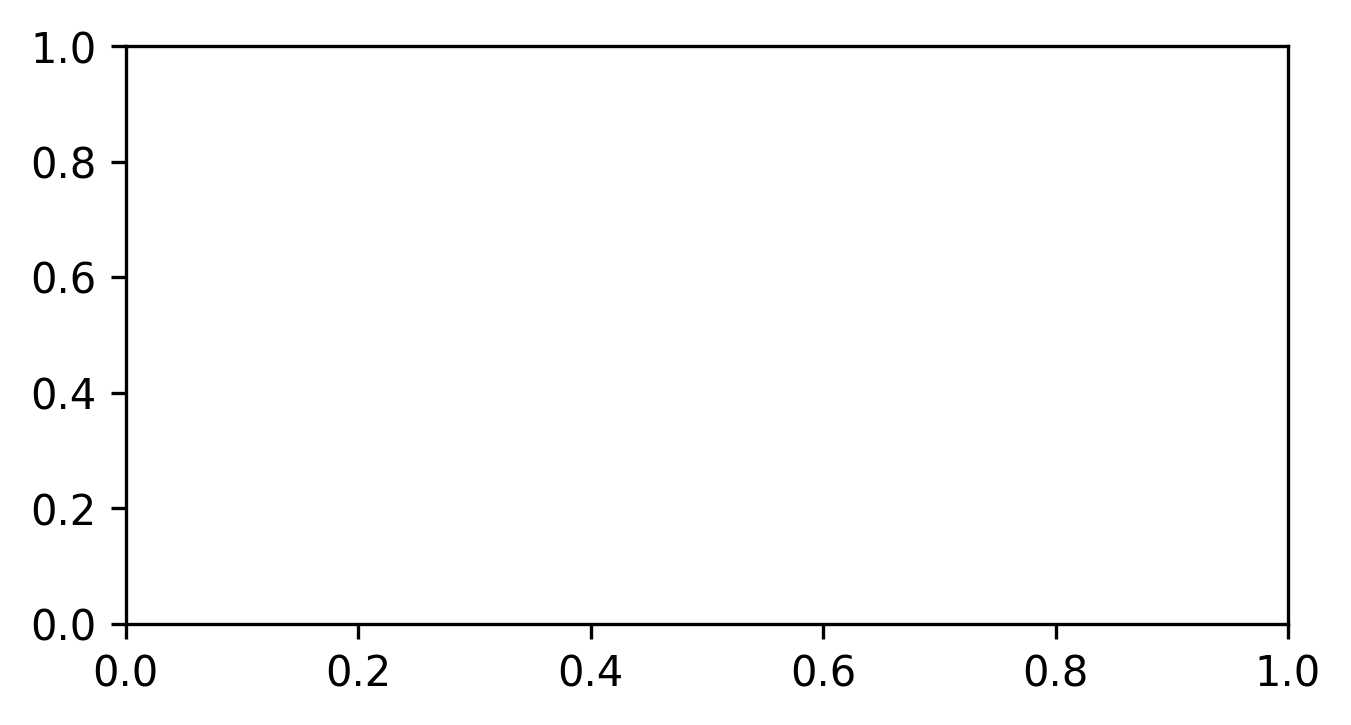

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(force_comsol[:, 0], force_comsol[:, 1]/fmax, label='$F_x^{COMSOL}$', linewidth=2, color='#1f77b4')
ax1.plot(Rs, F_x_from_R[:,0]/fmax, label='$F_x^{Theory}$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('R, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig('force_comsol_theory.pdf', dpi=300)
plt.show()


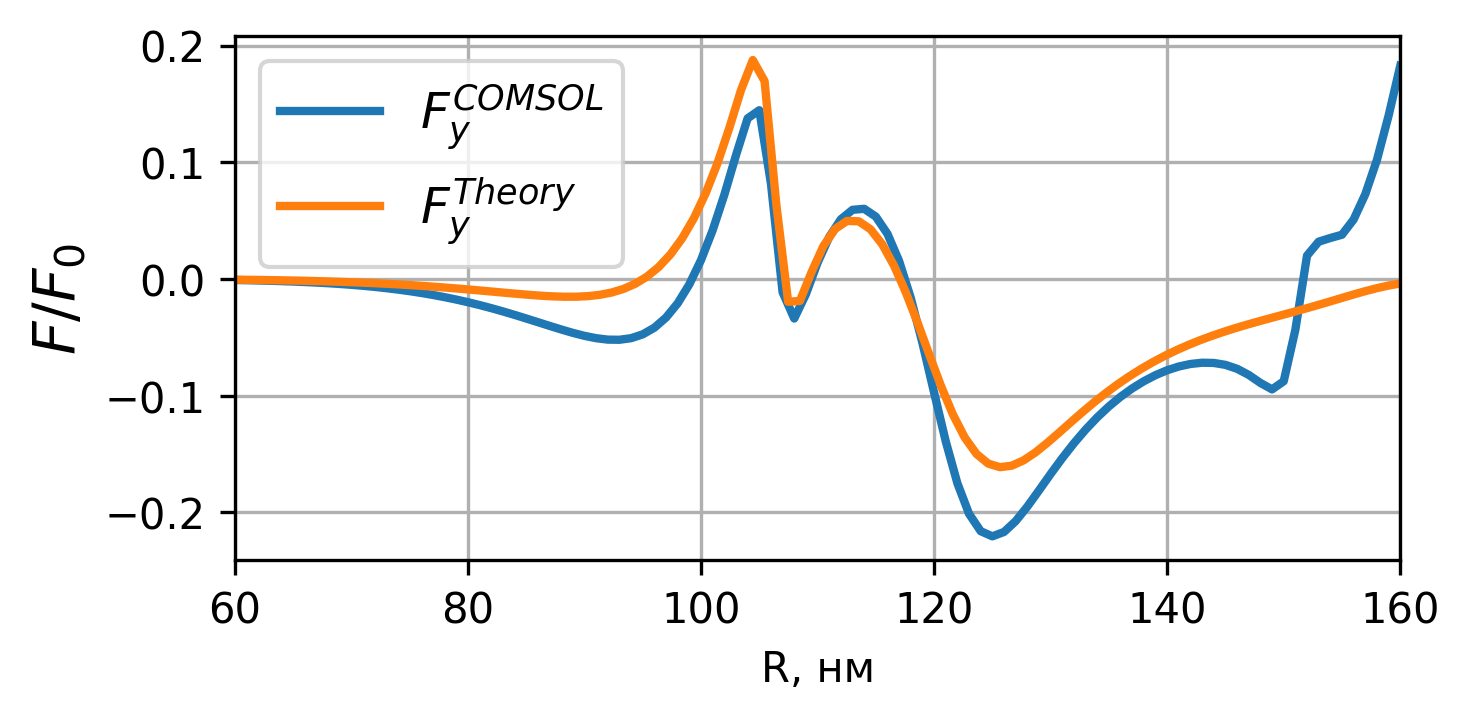

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), sharex=True, dpi=300)

# Первый график: ED и MD
ax1.plot(force_comsol[:, 0], force_comsol[:, 2]/fmax, label='$F_y^{COMSOL}$', linewidth=2, color='#1f77b4')
ax1.plot(Rs, F_y_from_R[:,0]/fmax, label='$F_y^{Theory}$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('R, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig('force_comsol_theory_y.pdf', dpi=300)
plt.show()


In [79]:
phi_D_fromR = np.empty(len(Rs))
for i in range(len(Rs)):
    j = np.argmax(directivityR[:,i])
    phi_D_fromR[i] = PHI[j]

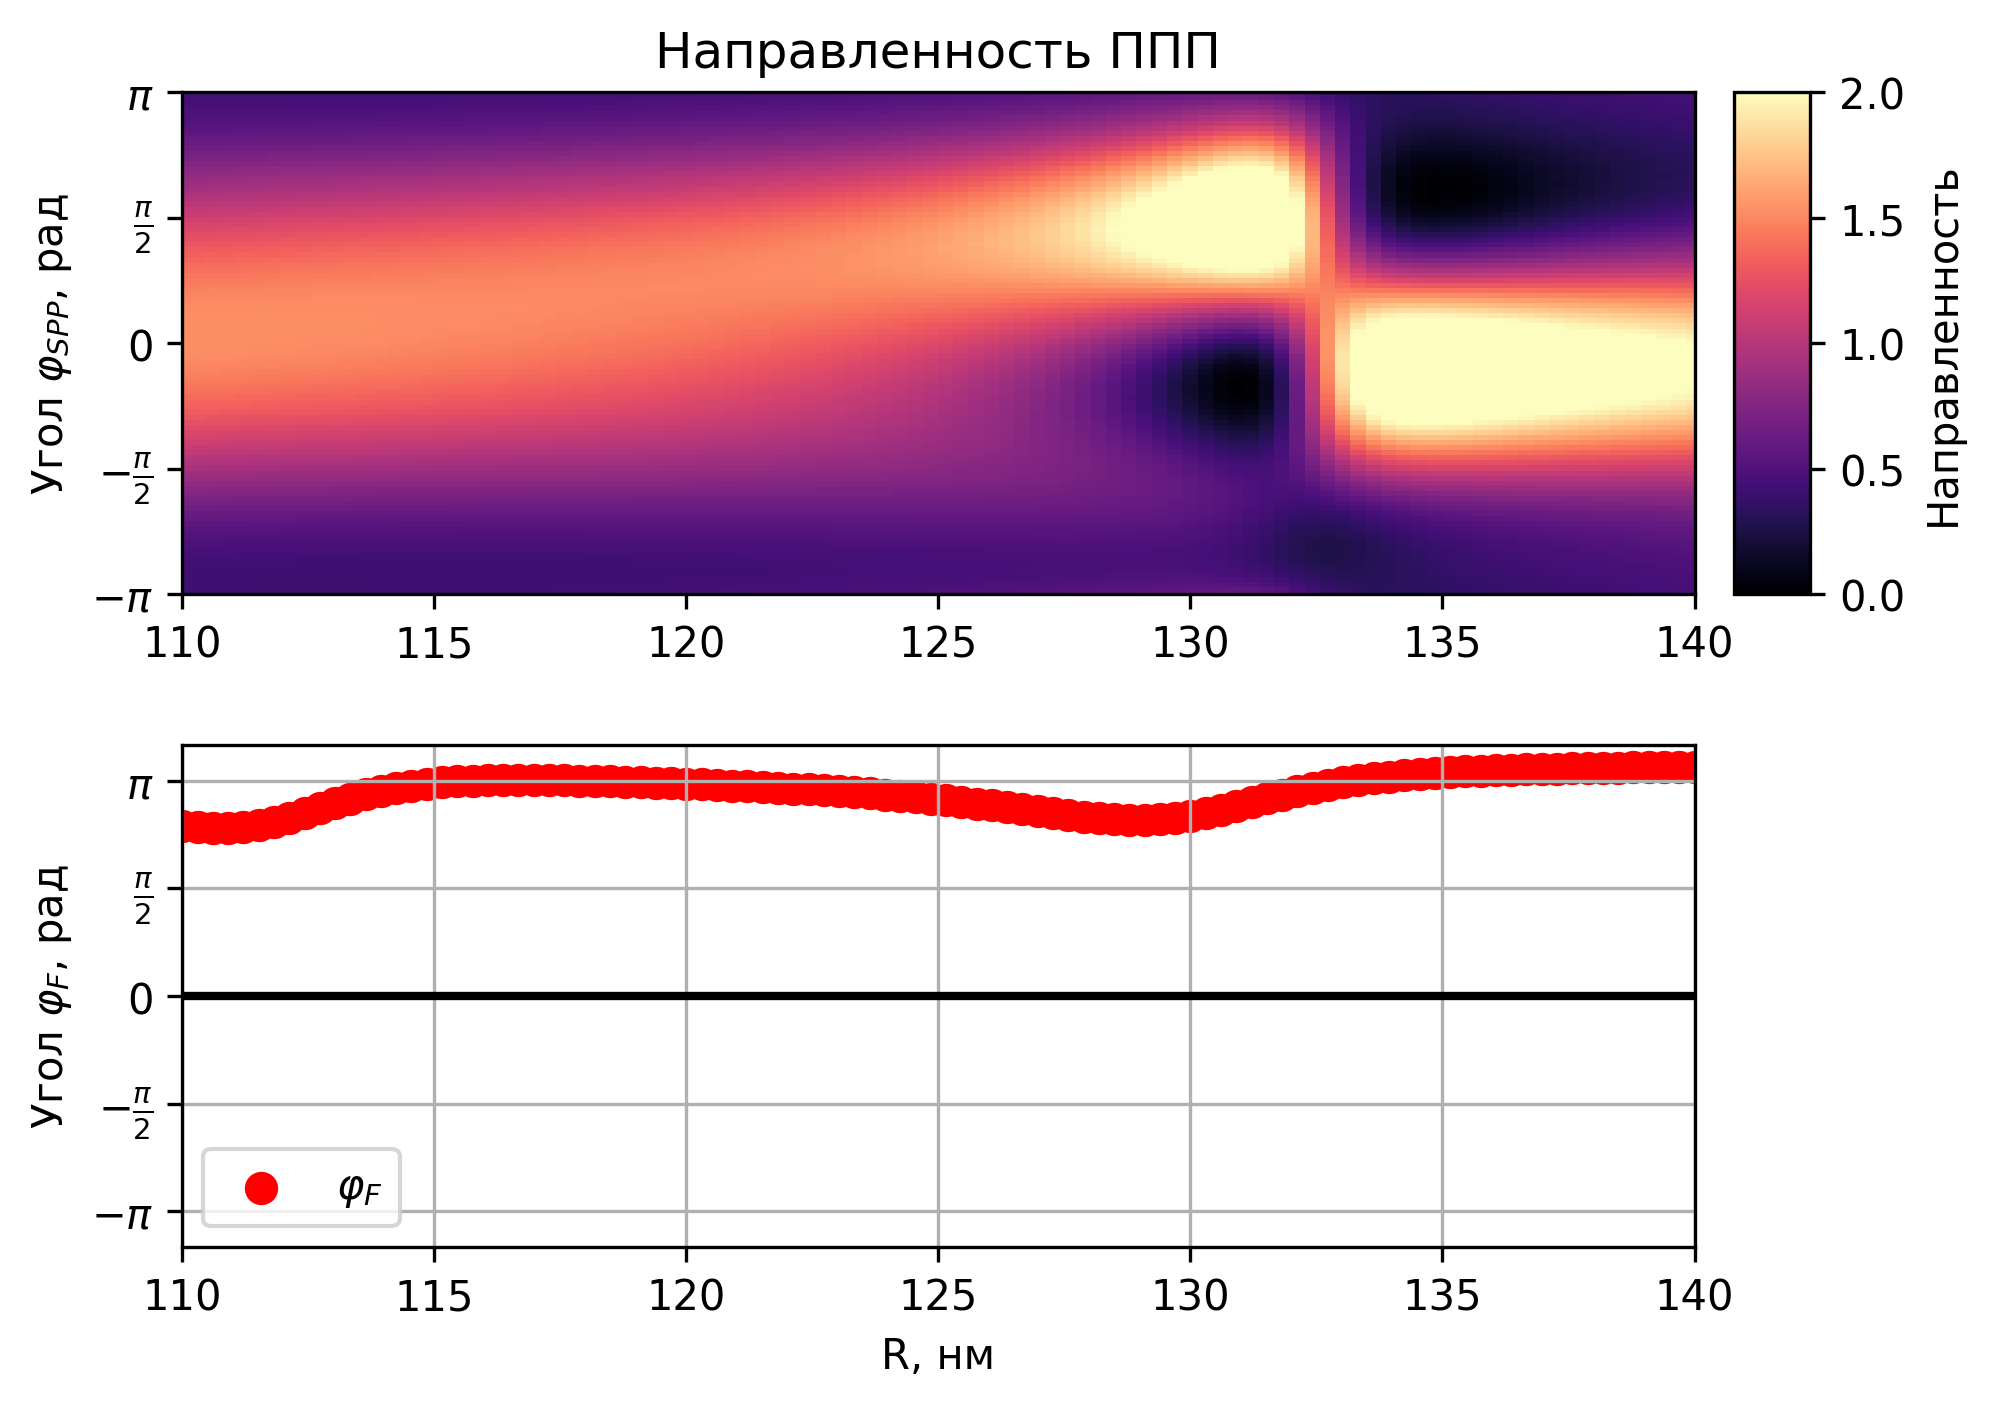

In [80]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# === Создание фигуры и макета ===
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(Rs, PHI, directivityR, cmap='magma', vmax=2, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
# y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
# y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(-np.pi, np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc_from_R = np.arctan2(F_y_from_R[:, 0], F_x_from_R[:, 0] - F_x_from_R[:, 1] - F_x_from_R[:, 4])
#angles_no_sc_from_R = np.unwrap(angles_no_sc_from_R)

angles_no_sc_from_R_no_crest = np.arctan2(F_y_from_R[:, 0]-F_y_from_R[:, 7] , F_x_from_R[:, 0] - F_x_from_R[:, 1] - F_x_from_R[:, 4] -F_x_from_R[:, 7] )


y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R+2*np.pi))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(Rs, np.unwrap(angles_no_sc_from_R), label=r'$\varphi_F$', color='r', linewidth=2)
ax_bottom.set_ylim(-7*np.pi/6, 7*np.pi/6)
ax_bottom.set_xlim(Rs[0], Rs[-1])
ax_bottom.set_xlabel('R, нм')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
plt.savefig(f'spp_vs_f_nosc_from_R_z0_{dist}.png', dpi=300)



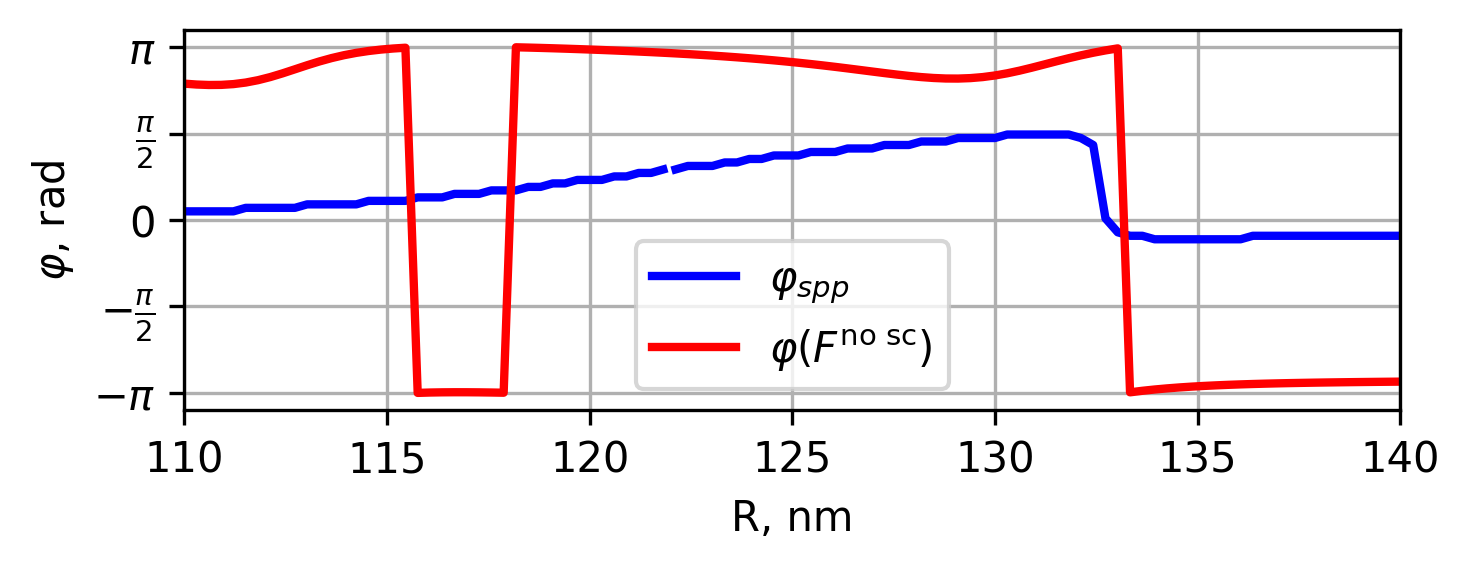

In [81]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(Rs[:40], phi_D_fromR[:40], label=r'$\varphi_{spp}$', c='blue', lw=2)
plt.plot(Rs[40:], phi_D_fromR[40:], c='blue', lw=2)
#plt.plot(Rs, angles_no_sc_from_R, label=r'$\varphi (F^{no\;sc})$', lw=2, c='r')
#plt.plot(Rs, np.arctan2(F_y_from_R[:,3]+F_y_from_R[:,6], F_x_from_R[:,3]+F_x_from_R[:,6]), label=r'$\varphi (F^{mp+pm})$', lw=2, c='r')

plt.plot(Rs, np.arctan2(F_y_from_R[:,0], F_x_from_R[:,0]-F_x_from_R[:,1]-F_x_from_R[:,4]), label=r'$\varphi (F^{\text{no sc}})$', lw=2, c='r')

plt.grid()
plt.legend()
# y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
# y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$',r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(y_ticks,y_ticklabels)
plt.xlim(Rs[0],Rs[-1])
plt.ylabel('$\\varphi$, rad')
plt.xlabel('R, nm')
plt.tight_layout()
plt.savefig(f'spp_vs_f_nosc_from_R_z0_{dist}_angle_plot.png', dpi=300)
plt.show()

(110.0, 140.0)

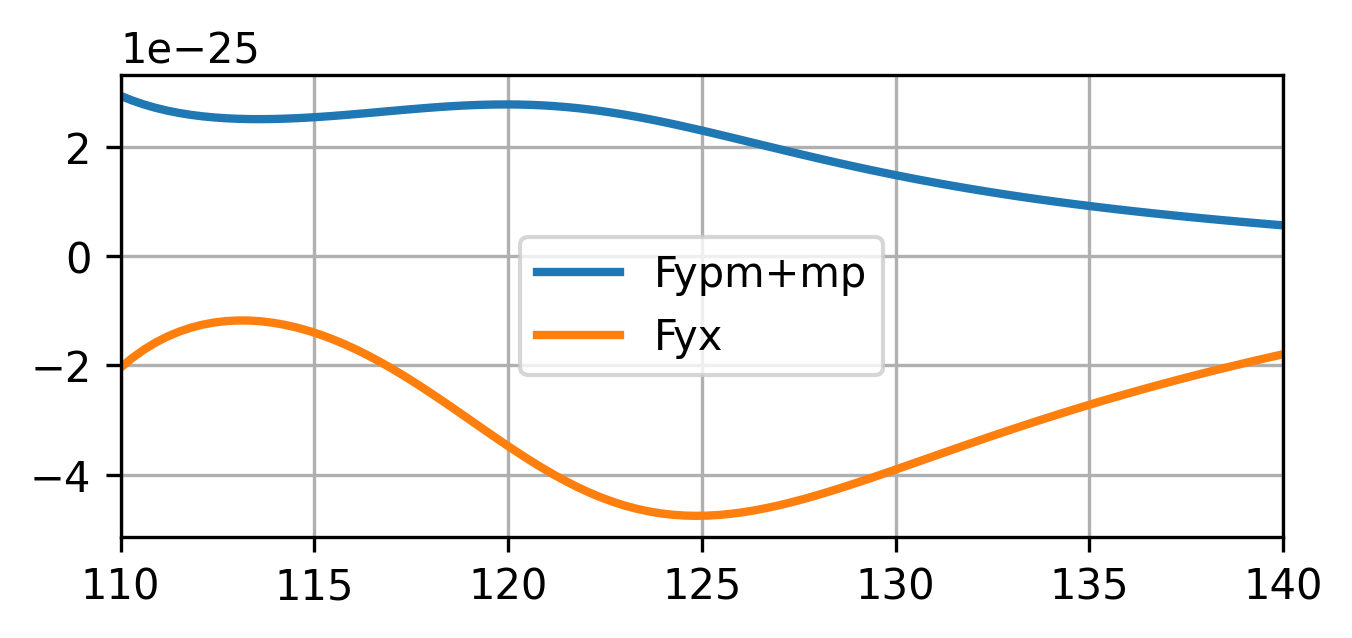

In [ ]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(Rs, F_y_from_R[:,6]+ F_y_from_R[:,3], lw=2, label='Fypm+mp')
plt.plot(Rs, F_y_from_R[:,7], lw=2, label='Fyx')
plt.grid()
plt.legend()
plt.xlim(Rs[0],Rs[-1])

(110.0, 140.0)

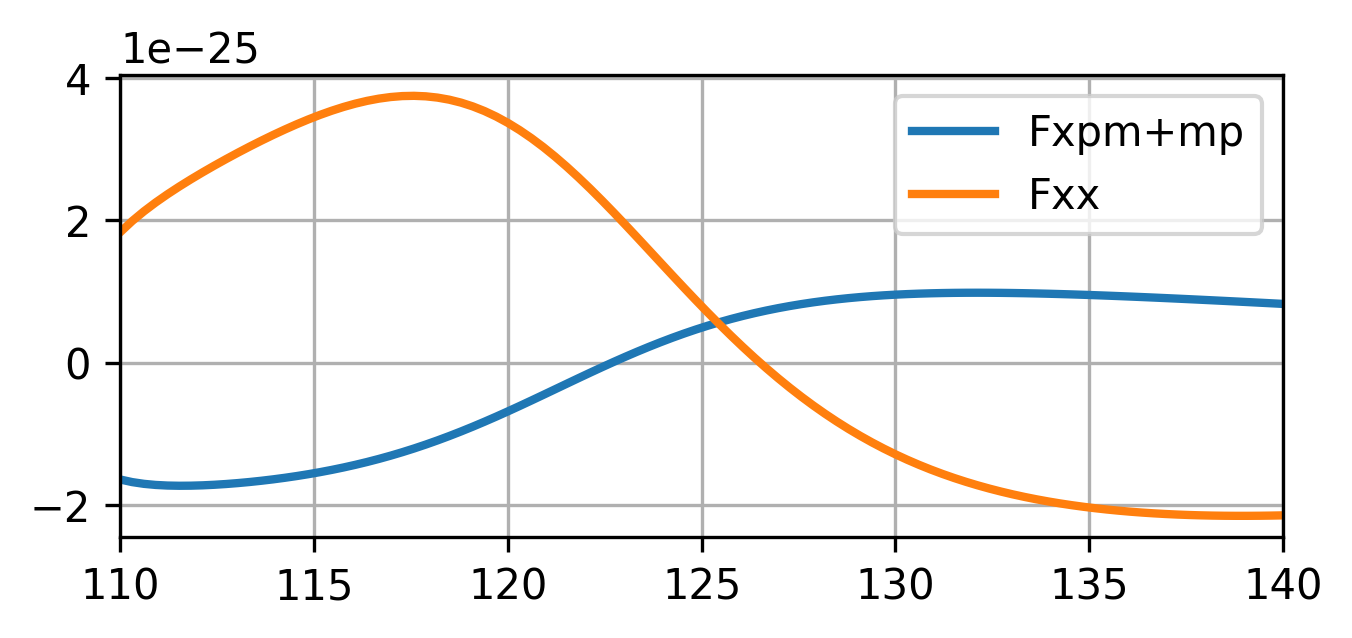

In [17]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(Rs, F_x_from_R[:,6]+ F_x_from_R[:,3], lw=2, label='Fxpm+mp')
plt.plot(Rs, F_x_from_R[:,7], lw=2, label='Fxx')
plt.grid()
plt.legend()
plt.xlim(Rs[0],Rs[-1])

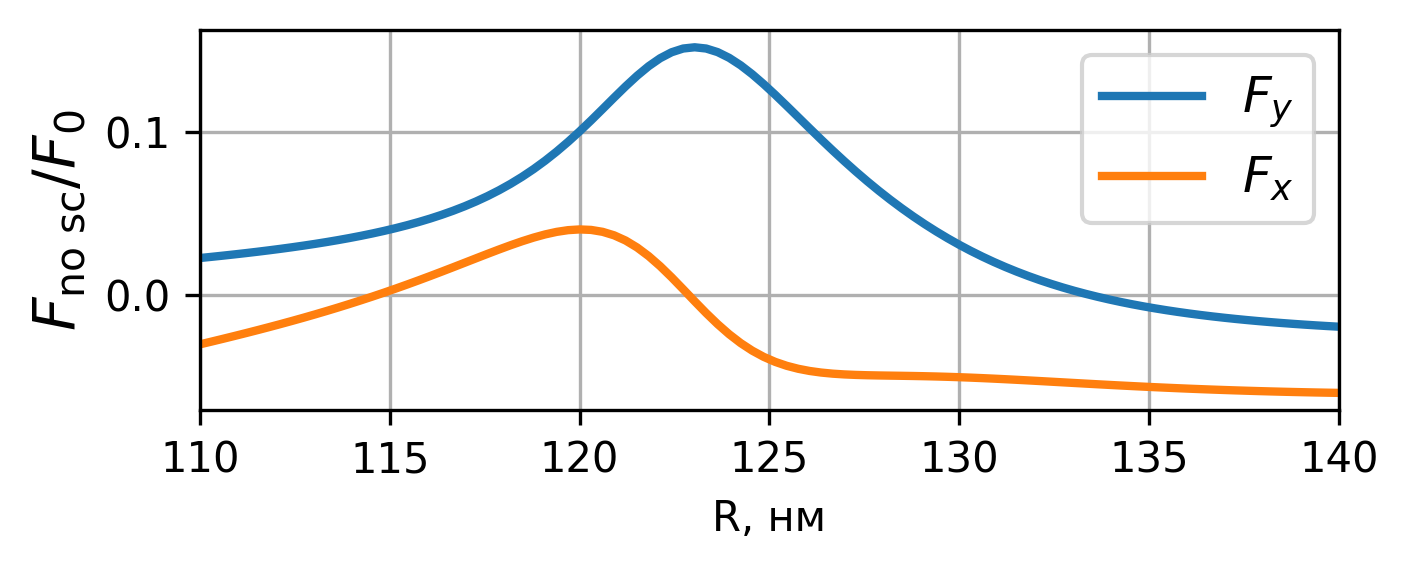

In [77]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2), sharex=True, dpi=300)


ax1.plot(Rs, (F_y_from_R[:,0])/fmax, label='$F_y$', linewidth=2, color='#1f77b4')
ax1.plot(Rs, (F_x_from_R[:,0]-(F_x_from_R[:,1]+F_x_from_R[:,4]))/fmax, label='$F_x$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel(r'$F_{\text{no sc}}/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('R, нм')

plt.xlim(Rs[0], Rs[-1])
plt.tight_layout()

plt.savefig(f'f_nosc_from_R_z0_{dist}.png', dpi=300)
plt.show()


In [22]:
fmax_Rs = 0
for i in range(len(Rs)):
    f0 = force.F(wl, 1, [0,0,0], Rs[i], eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_Rs:
        fmax_Rs = f0

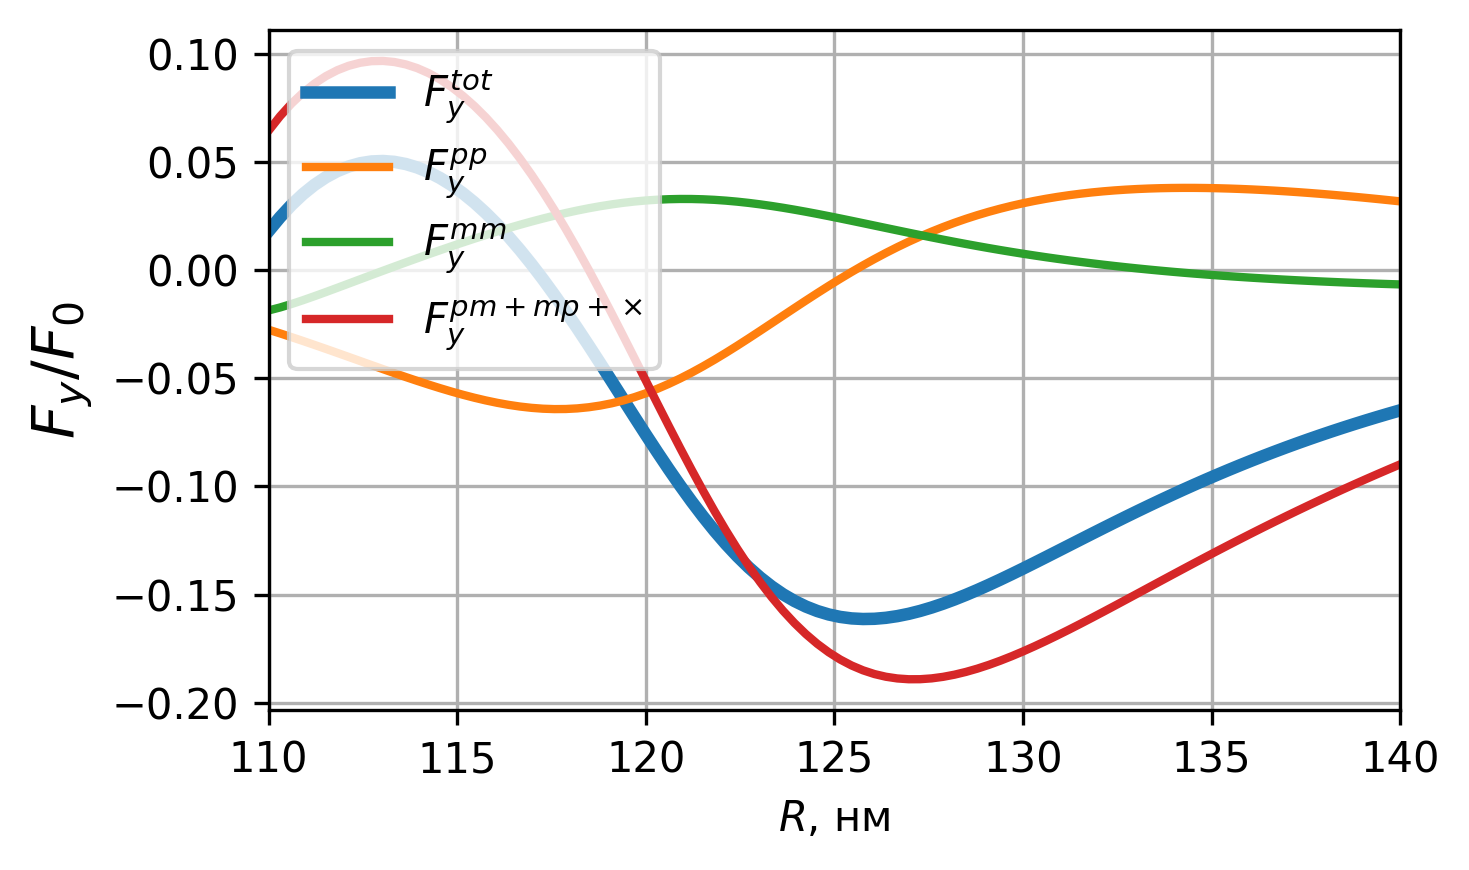

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(Rs, F_y_from_R[:,0]/fmax_Rs, label='$F_y^{tot}$', linewidth=3)
ax1.plot(Rs, F_y_from_R[:,2]/fmax_Rs, label='$F_y^{pp}$', linewidth=2)
ax1.plot(Rs, F_y_from_R[:,5]/fmax_Rs, label='$F_y^{mm}$', linewidth=2)
ax1.plot(Rs, (F_y_from_R[:,6]+F_y_from_R[:,3]+F_y_from_R[:,7])/fmax_Rs, label='$F_y^{pm+mp+\\times}$', linewidth=2)

ax1.set_ylabel('$F_y/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(loc='upper left')
ax1.set_xlabel('$R$, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig(f'f_no_sc_y_from_Rs_z0_{dist}.pdf', dpi=300)
plt.show()


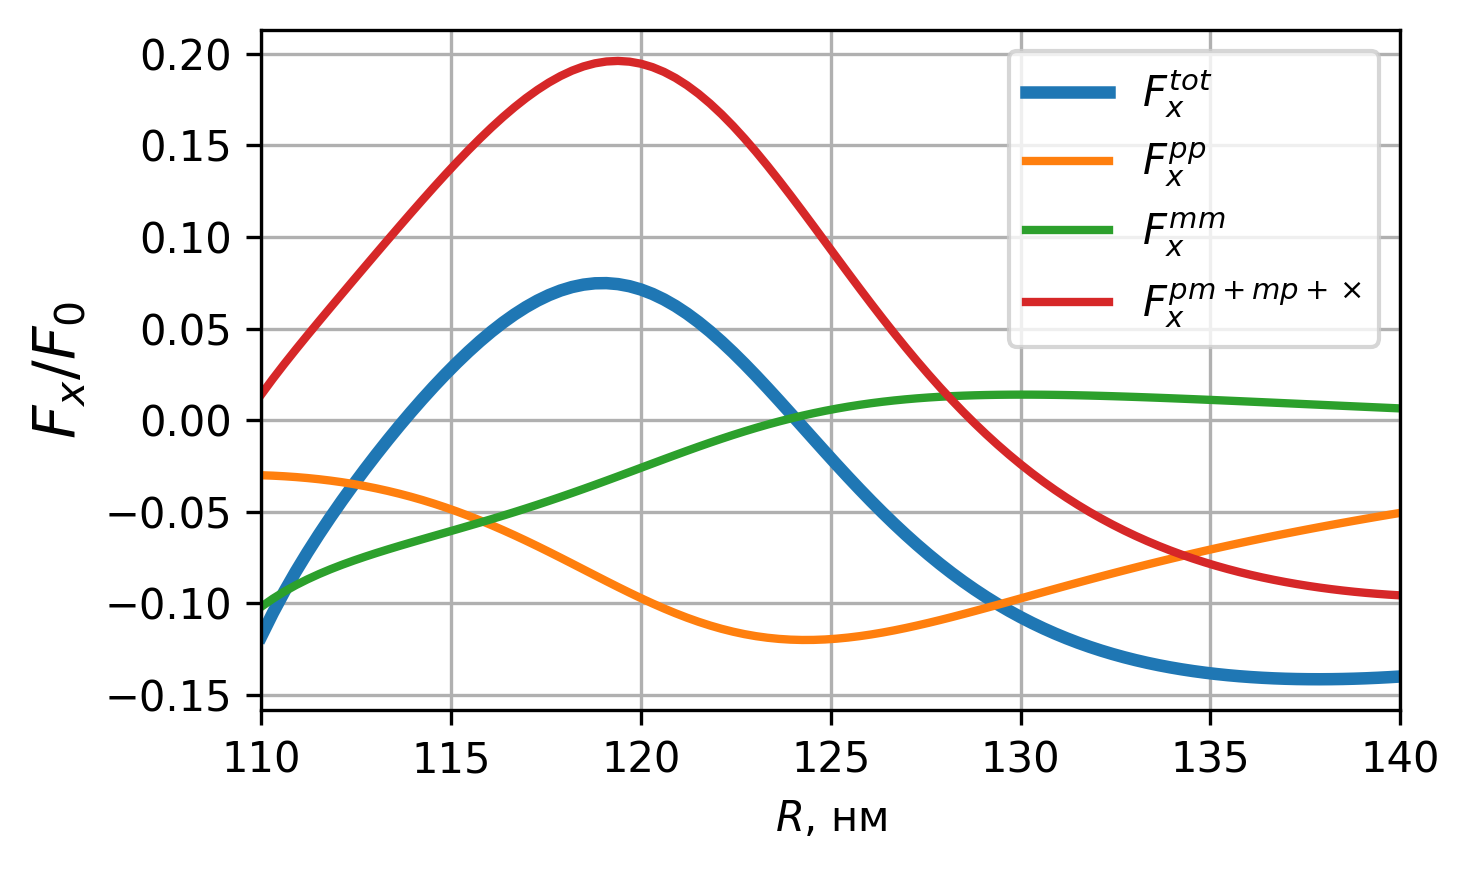

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(Rs, (F_x_from_R[:,0]-F_x_from_R[:,1]-F_x_from_R[:,4])/fmax_Rs, label='$F_x^{tot}$', linewidth=3)
ax1.plot(Rs, F_x_from_R[:,2]/fmax_Rs, label='$F_x^{pp}$', linewidth=2)
ax1.plot(Rs, F_x_from_R[:,5]/fmax_Rs, label='$F_x^{mm}$', linewidth=2)
ax1.plot(Rs, (F_x_from_R[:,6]+F_x_from_R[:,3] +F_x_from_R[:,7] )/fmax_Rs, label='$F_x^{pm+mp+\\times}$', linewidth=2)
#ax1.plot(Rs, F_x_from_R[:,7]/fmax_Rs, label='$F_x^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_x/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend()
ax1.set_xlabel('$R$, нм')

plt.xlim(Rs[0], Rs[-1])

plt.tight_layout()
plt.savefig(f'f_no_sc_x_from_Rs_z0_{dist}.pdf', dpi=300)
plt.show()


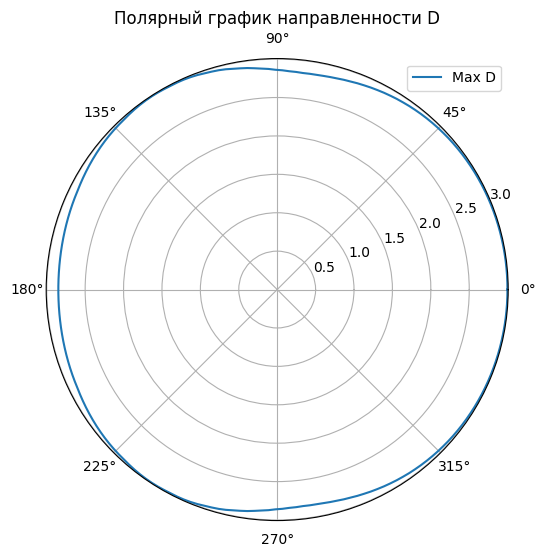

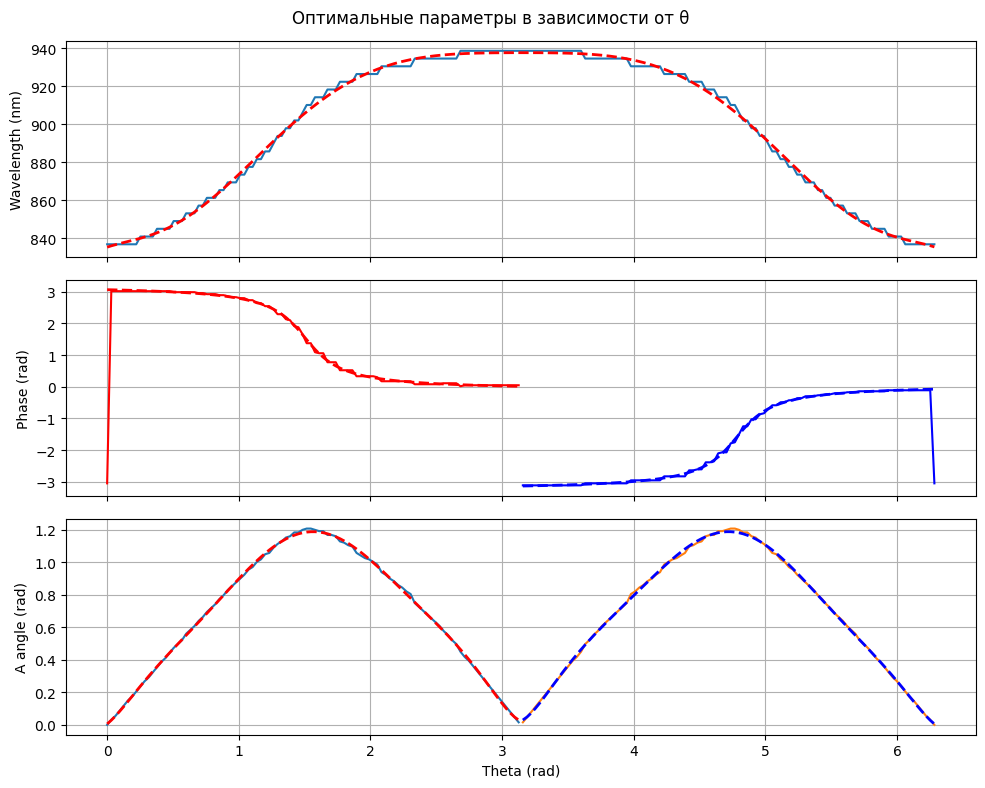

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

# Загрузка данных
data = np.load('spp_optim_clean_v3.npz', allow_pickle=True)
results = data['results']
thetas = data['thetas']

# Извлечение параметров
D = np.array([r['D'] for r in results])
wl = np.array([r['wl'] for r in results])
phase = np.array([r['phase'] for r in results])
a_angle = np.array([r['a_angle'] for r in results])

# Полярный график зависимости D от θ
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(thetas, D, label='Max D')
ax.set_title("Полярный график направленности D")
plt.legend()
plt.show()

# Графики параметров (обычные)
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axs[0].plot(thetas, wl)
deg = 8
coefs_wl = Polynomial.fit(thetas, wl, deg).convert().coef
wl_fit = Polynomial(coefs_wl)

axs[0].plot(thetas, wl_fit(thetas), linestyle='--', label='Interpolated', lw=2, c='r')
axs[0].set_ylabel("Wavelength (nm)")
axs[0].grid(True)

def fitfunc(x, A, B, C, D):
    return np.atan( x * A + B) *C  + D

separ = 100
theta1 = thetas[:separ]
phase1 = phase[:separ]
theta2 = thetas[separ:]
phase2 = phase[separ:]
a_angle1 = a_angle[:separ]
a_angle2 = a_angle[separ:]


params_phase1, _ = curve_fit(fitfunc, theta1[1:], phase1[1:], p0=[1, 0, 1, 0])

phase1_fit =  lambda x: fitfunc(x, *params_phase1)

axs[1].plot(theta1, phase1, c='r', label='Phase')
axs[1].plot(theta1, phase1_fit(theta1), linestyle='--', label='Interpolated', lw=2, c='r')

params_phase2, _ = curve_fit(fitfunc, theta2[:-1], phase2[:-1], p0=[1, 0, 1, 0])
phase2_fit =  lambda x: fitfunc(x, *params_phase2)
axs[1].plot(theta2, phase2, c='b', label='Phase')
axs[1].plot(theta2, phase2_fit(theta2), linestyle='--', label='Interpolated', lw=2, c='b')

axs[1].set_ylabel("Phase (rad)")
axs[1].grid(True)


axs[2].plot(theta1, a_angle1)

deg = 8
coefs_a1 = Polynomial.fit(theta1, a_angle1, deg).convert().coef
a1_fit = Polynomial(coefs_a1)

axs[2].plot(theta1, a1_fit(theta1), linestyle='--', label='Interpolated', lw=2, c='r')


axs[2].plot(theta2, a_angle2)
deg = 8
coefs_a2 = Polynomial.fit(theta2, a_angle2, deg).convert().coef
a2_fit = Polynomial(coefs_a2)

axs[2].plot(theta2, a2_fit(theta2), linestyle='--', label='Interpolated', lw=2, c='b')


axs[2].set_ylabel("A angle (rad)")
axs[2].set_xlabel("Theta (rad)")
axs[2].grid(True)

fig.suptitle("Оптимальные параметры в зависимости от θ")
plt.tight_layout()
plt.show()


In [5]:
def smooth_params(theta):
    
    if np.any((theta < 0) | (theta > 2 * np.pi)):
        raise ValueError("Theta must be in the range [0, 2π].")
    
    wl = wl_fit(theta)
    phase = np.where(theta < np.pi, phase1_fit(theta), phase2_fit(theta))
    amp = np.where(theta < np.pi, a1_fit(theta), a2_fit(theta))
    return wl, phase, amp

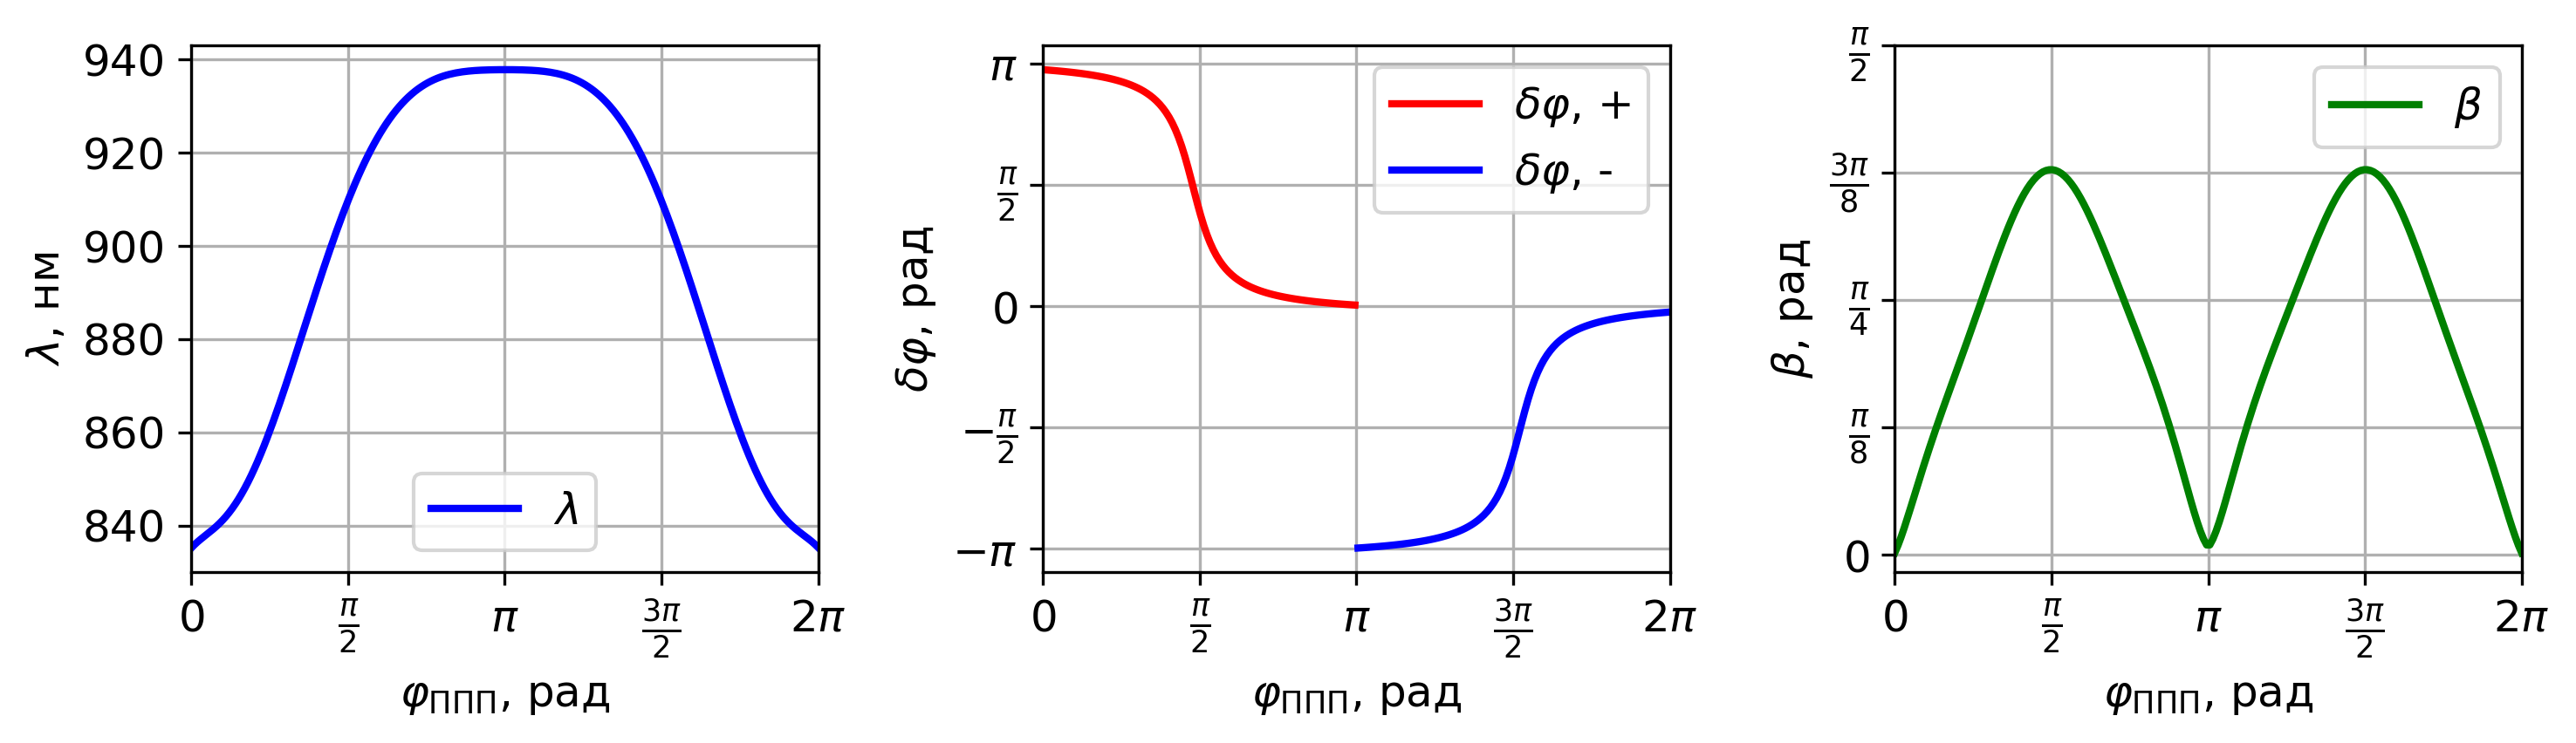

In [50]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=300)



ax1, ax2, ax3 = axes

ax1.plot(thetas, smooth_params(thetas)[0], label=r'$\lambda$', lw=2, c='blue')
ax1.set_ylabel(r'$\lambda$, нм')

ax2.plot(thetas[:separ], smooth_params(thetas[:separ])[1], label=r'$\delta \varphi$, +', lw=2, c='r')
xticks = np.linspace(0, 2*np.pi, 5)  # 0, π/2, π, 3π/2, 2π
xticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
ax2.set_ylabel(r'$\delta \varphi$, рад')

ax2.plot(thetas[separ:], smooth_params(thetas[separ:])[1], label=r'$\delta \varphi$, -', lw=2, c='b')
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels([r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])


ax3.plot(thetas, smooth_params(thetas)[2], label=r'$\beta$', lw=2, c='g')
ax3.set_yticks([0, np.pi/8,np.pi/4, 3*np.pi/8, np.pi/2])
ax3.set_yticklabels([r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'])
ax3.set_ylabel(r'$\beta$, рад')

xticks = np.linspace(0, 2*np.pi, 5)  # 0, π/2, π, 3π/2, 2π
xticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xlabel(r'$\varphi_{\text{ППП}}$, рад')
    ax.grid(True)
    ax.legend()
plt.tight_layout()
plt.savefig('polaris_params_.pdf')
plt.show()

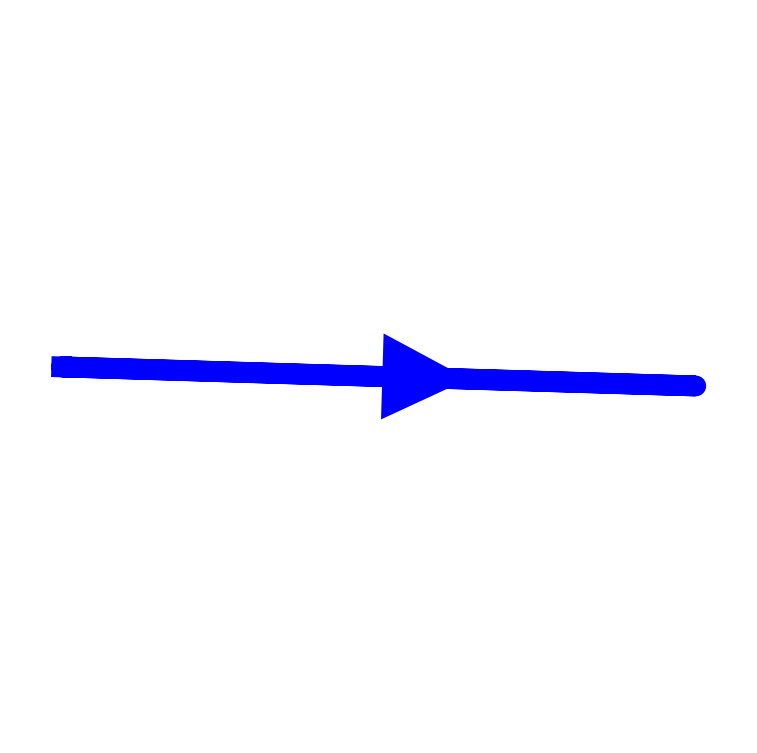

In [165]:
import numpy as np
import matplotlib.pyplot as plt

ind = 100
# Параметры
_, phaseee, betaaaa= smooth_params(thetas[ind])
A_TM = np.cos(betaaaa)    
A_TE = np.sin(betaaaa)          
t = np.linspace(0, 2*np.pi, 1000)

TE = A_TE * np.cos(t)
TM = A_TM * np.cos(t + phaseee)

# Построение эллипса
plt.figure(figsize=(3, 3), dpi=300)

plt.plot(TM, TE, lw=5, c='b')
plt.quiver(TM[:-1], TE[:-1], 
           np.diff(TM), np.diff(TE), 
           scale_units='xy', angles='xy', scale=1, width=0.002,
           color='b', alpha=0.3)

# Стрелка направления вращения
idx =250 # индекс для стрелки
plt.arrow(TM[idx], TE[idx],
          TM[idx+1] - TM[idx], TE[idx+1] - TE[idx],
          head_width=0.25, head_length=0.25, fc='b', ec='b', zorder=2)

# Настройки графика
plt.axis('equal')
plt.axis('off')
plt.savefig(f'ellipse_polarisation_{ind}.svg', bbox_inches='tight', dpi=300, transparent=True)
plt.show()


In [168]:
from tqdm import tqdm as tdqm

PHI_ANGLES = np.linspace(0, 2 * np.pi, 100)
STOP = 35
R=295/2
dist=2
ANGLE=25*np.pi/180
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')
point = [0,0, dist+R]

P_smooth = np.empty((len(PHI_ANGLES), 3), dtype=complex)
M_smooth = np.empty((len(PHI_ANGLES), 3), dtype=complex)
F_x_smooth = np.empty((len(PHI_ANGLES),8))
F_y_smooth = np.empty_like(F_x_smooth)
F_z_smooth = np.empty_like(F_x_smooth)

for i, theta in tdqm(enumerate(PHI_ANGLES)):
    wl, phase, a_angle = smooth_params(theta)
    p, m = dipoles.calc_dipoles_v2(wl, eps_Au, point, R, eps_Si, ANGLE, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    P_smooth[i,:], M_smooth[i,:] = p[:,0], m[:,0]
    
    f = force.F(wl, eps_Au, point, R, eps_Si, ANGLE, amplitude=1,phase=phase, a_angle=a_angle, stop=STOP, full_output=True)
    F_x_smooth[i,:] = f[0]
    F_y_smooth[i,:] = f[1]
    F_z_smooth[i,:] = f[2]

100it [04:16,  2.56s/it]


In [169]:
PHI = np.linspace(-np.pi, np.pi, 100)

directivity_smooth = np.empty((len(PHI), len(PHI_ANGLES)))
for id in range(len(PHI_ANGLES)):
    for angle_idx in range(len(PHI)):
        wl, phase, a_angle = smooth_params(theta)
        D_fun = get_directivity(wl, P_smooth[id], M_smooth[id], eps_Au)
        directivity_smooth[angle_idx, id] = D_fun(PHI[angle_idx])

In [167]:
PHI = np.linspace(-np.pi, np.pi, 100)
STOP = 35
R=295/2
dist=2
angle=25*np.pi/180

eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

point = [0,0, dist+R]

P_opt = np.array([r['P'] for r in results])
M_opt = np.array([r['M'] for r in results])



directivity_opt = np.empty((len(PHI), len(results)))
for id in range(len(results)):
    for angle_idx in range(len(PHI)):
        D_fun = get_directivity(wl[id], P_opt[id], M_opt[id], eps_Au)
        directivity_opt[angle_idx, id] = D_fun(PHI[angle_idx])
        
        
F_x_opt = np.empty((len(results), 8))
F_y_opt = np.empty((len(results), 8))
F_z_opt = np.empty((len(results), 8))
for i in tqdm(range(len(results))):
    f =  force.F(wl[i], eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase[i],a_angle=a_angle[i], stop=STOP, full_output=True)
    F_x_opt[i,:] = f[0]
    F_y_opt[i,:] = f[1]
    F_z_opt[i,:] = f[2]

IndexError: invalid index to scalar variable.

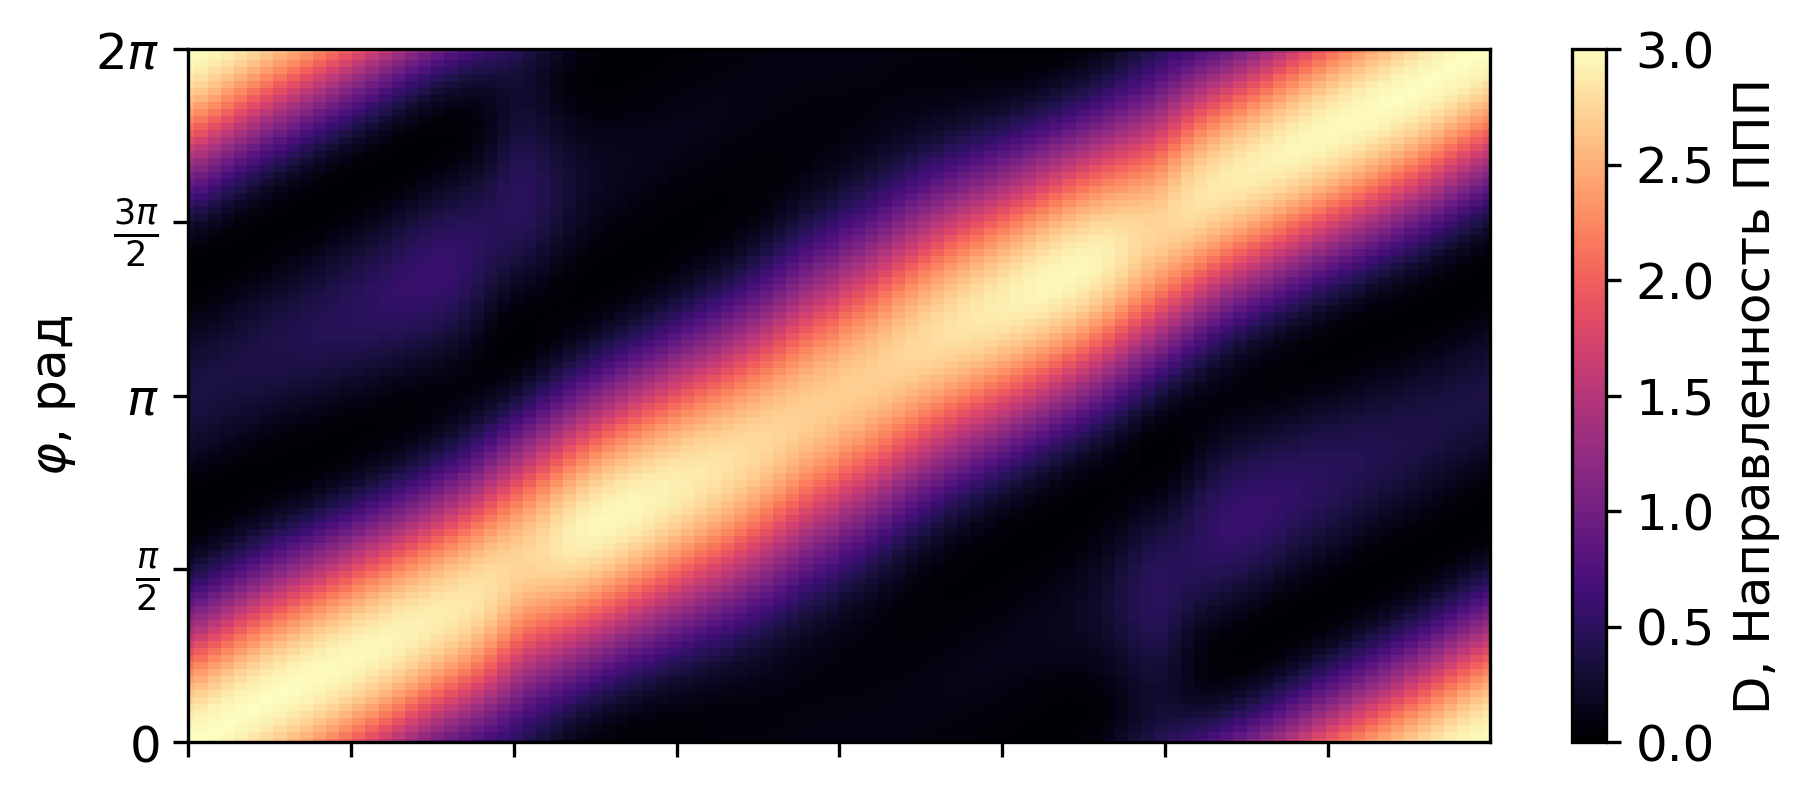

In [140]:
plt.figure(figsize=(7, 3), dpi=300)

directivity_map = plt.pcolor(PHI_ANGLES, PHI, directivity_smooth, cmap='magma', vmax=3, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
#y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
#y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(y_ticks, y_ticklabels)

plt.ylim(0, 2*np.pi)
plt.ylabel(r'$\varphi$, рад')
xticks = np.arange(0, 2*np.pi, np.pi/4)

plt.xticks(xticks, [])
plt.xlim(0,2*np.pi)
# plt.xlabel(r'$\varphi_{ППП}$, рад')

plt.colorbar(directivity_map, label='D, Направленность ППП')
plt.savefig('directivity_map.png', dpi=600)

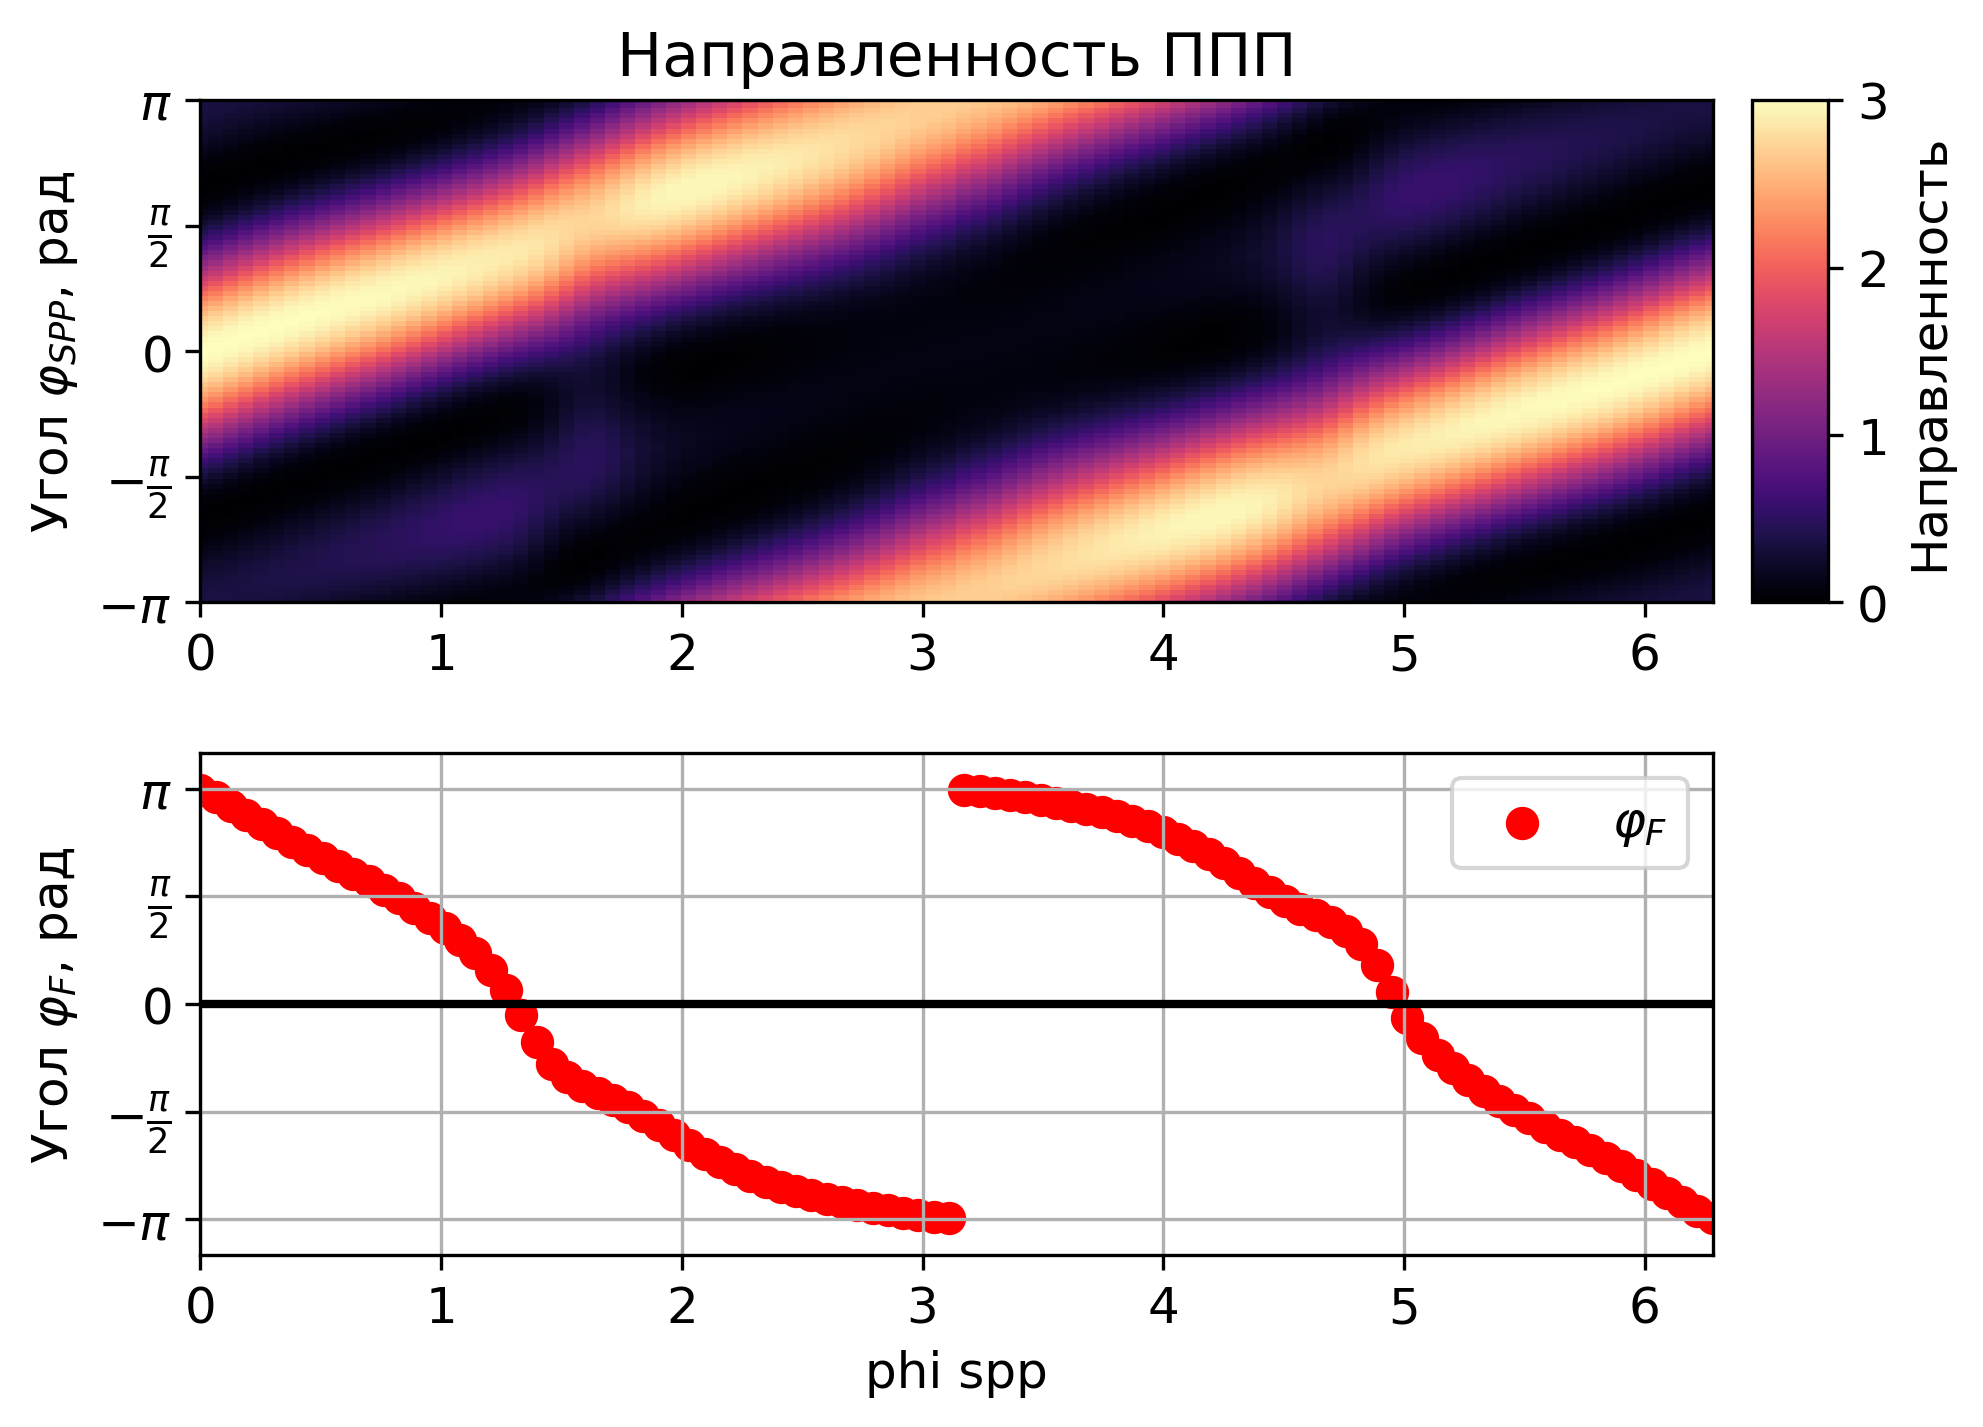

In [267]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7, 5), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[20, 1], height_ratios=[1, 1], hspace=0.3, wspace=0.05)

# === Верхний график (тепловая карта) ===
ax_top = fig.add_subplot(gs[0, 0])
directivity_map = ax_top.pcolor(PHI_ANGLES, PHI, directivity_smooth, cmap='magma', vmax=3, vmin=0)

# Настройка оси Y: метки углов в виде кратных π
# y_ticks = [0, np.pi/2, np.pi, np.pi*3/2, 2*np.pi]
# y_ticklabels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$']
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_top.set_yticks(y_ticks)
ax_top.set_yticklabels(y_ticklabels)

ax_top.set_ylim(-np.pi, np.pi)
ax_top.set_ylabel(r'Угол $\varphi_{SPP}$, рад')
ax_top.set_title('Направленность ППП')

# === Colorbar ===
cax = fig.add_subplot(gs[0, 1])
fig.colorbar(directivity_map, cax=cax, label='Направленность')

# === Нижний график (углы силы) ===
ax_bottom = fig.add_subplot(gs[1, 0], sharex=ax_top)

angles_no_sc_from_R = np.arctan2(F_y_smooth[:, 0]   ,F_x_smooth[:, 0] - F_x_smooth[:, 1] - F_x_smooth[:, 4] )
#angles_no_sc_from_R = np.unwrap(angles_no_sc_from_R)

angles_no_sc_from_R_no_Fcrest = np.arctan2(F_y_smooth[:, 0]- F_y_smooth[:, 7]  ,F_x_smooth[:, 0] - F_x_smooth[:, 1] - F_x_smooth[:, 4] -F_x_smooth[:, 7] )

angles_Fcrest = np.arctan2(F_y_smooth[:, 7], F_x_smooth[:, 7])

angles_Fee = np.arctan2(F_y_smooth[:, 2] , F_x_smooth[:, 2] )
angles_Fmm = np.arctan2(F_y_smooth[:, 5] , F_x_smooth[:, 5] )
angles_Femme = np.arctan2(F_y_smooth[:, 6] + F_y_smooth[:, 3], F_x_smooth[:, 6] + F_x_smooth[:, 3])

y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
ax_bottom.set_yticks(y_ticks)
ax_bottom.set_yticklabels(y_ticklabels)
ax_bottom.axhline(0, color='black', linestyle='-', linewidth=2)
# closest_to_zero_idx = np.argmin(np.abs(angles_no_sc_from_R+2*np.pi))
# approx_zero_crossing_x = Rs[closest_to_zero_idx]
# ax_bottom.axvline(approx_zero_crossing_x, color='black', linestyle='--', linewidth=2)
ax_bottom.scatter(PHI_ANGLES, angles_no_sc_from_R_no_Fcrest, label=r'$\varphi_F$', color='r', linewidth=2)
ax_bottom.set_ylim(-7*np.pi/6, 7*np.pi/6)
ax_bottom.set_xlim(0, 2*np.pi)
ax_bottom.set_xlabel('phi spp')
ax_bottom.set_ylabel(r'Угол $\varphi_F$, рад')
ax_bottom.grid(True)
ax_bottom.legend()
#plt.savefig(f'spp_vs_f_nosc_from_R_z0_{dist}.png', dpi=300)



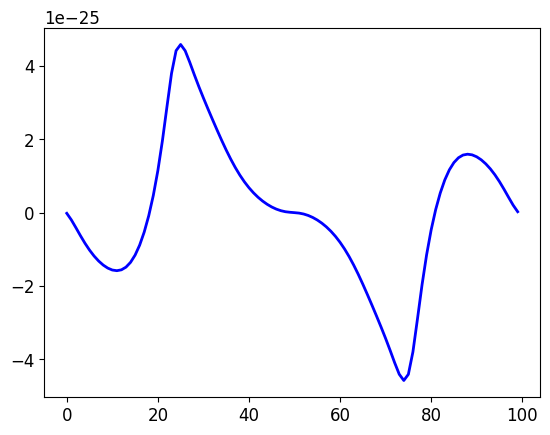

In [172]:
plt.plot(range(len(PHI_ANGLES)), F_y_smooth[:,7], lw=2, c='b')
#plt.plot(range(len(results)), F_x_opt[:,0]-F_x_opt[:,1]-F_x_opt[:,4], lw=2, c='r')

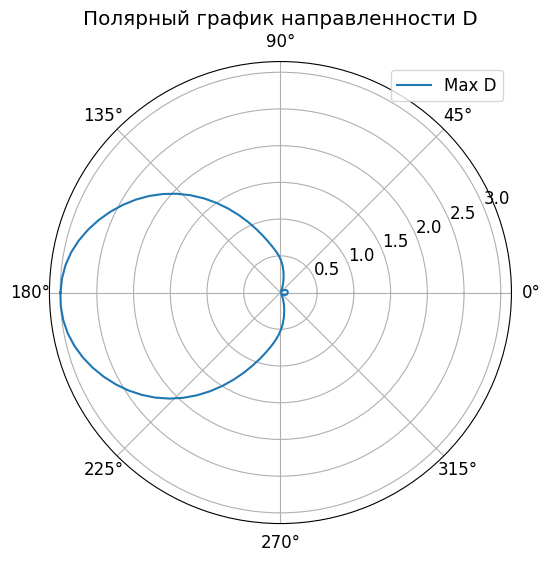

In [178]:
ind =50
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
ax.plot(PHI, directivity_smooth[ind,:], label='Max D')
ax.set_title("Полярный график направленности D")
plt.legend()
plt.show()

In [ ]:
wls = np.linspace(800, 1000, 50)
fmax_wls = 0
for i in range(len(wls)):
    f0 = force.F(wls[i], 1, [0,0,0], R, eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
    f0 = np.abs(f0)
    if f0 > fmax_wls:
        fmax_wls = f0

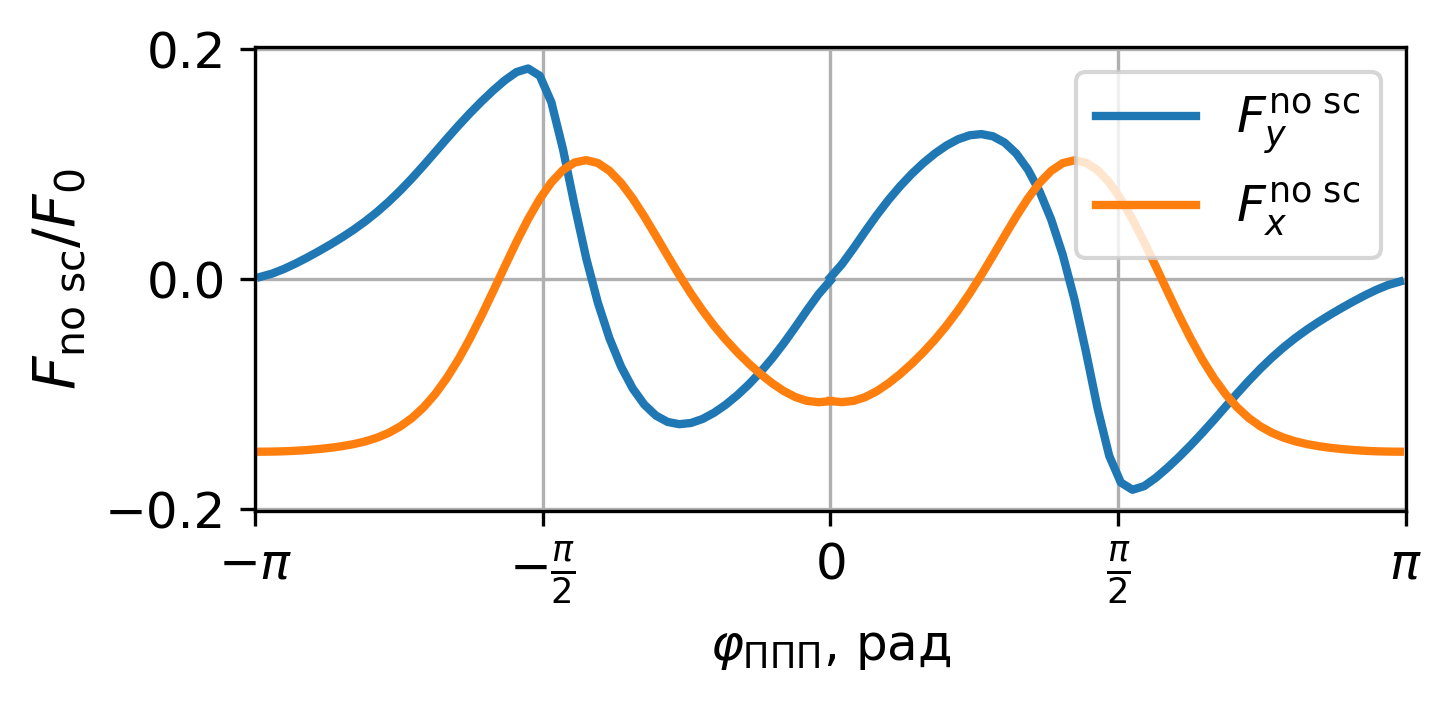

In [269]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2.5), sharex=True, dpi=300)
PHI_wrapped = (PHI_ANGLES + np.pi) % (2 * np.pi) - np.pi

ax1.plot(PHI_wrapped[:50], (F_y_smooth[:50,0]-F_y_smooth[:50,7])/fmax_wls, label=r'$F_y^{\text{no sc}}$', linewidth=2, color='#1f77b4')
ax1.plot(PHI_wrapped[:50], (F_x_smooth[:50,0]-F_x_smooth[:50,1]-F_x_smooth[:50,4]-F_x_smooth[:50,7])/fmax_wls, label=r'$F_x^{\text{no sc}}$', linewidth=2, color='#ff7f0e')

ax1.plot(PHI_wrapped[50:], (F_y_smooth[50:,0]-F_y_smooth[50:,7])/fmax_wls,linewidth=2, color='#1f77b4')
ax1.plot(PHI_wrapped[50:], (F_x_smooth[50:,0]-F_x_smooth[50:,1]-F_x_smooth[50:,4]-F_x_smooth[50:,7])/fmax_wls, linewidth=2, color='#ff7f0e')

y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']

plt.xticks(y_ticks,y_ticklabels)
ax1.set_ylabel(r'$F_{\text{no sc}}/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel(r'$\varphi_{\text{ППП}}$, рад')

plt.xlim(-np.pi, np.pi)

plt.tight_layout()
plt.tight_layout()
plt.savefig('fxy_spp_dir_no_scret.pdf', dpi=300)

plt.show()

In [190]:
phiii = np.empty(len(PHI_ANGLES))
for i in range(len(PHI_ANGLES)):
    j = np.argmax(directivity_smooth[:,i])
    phiii[i] = PHI[j]


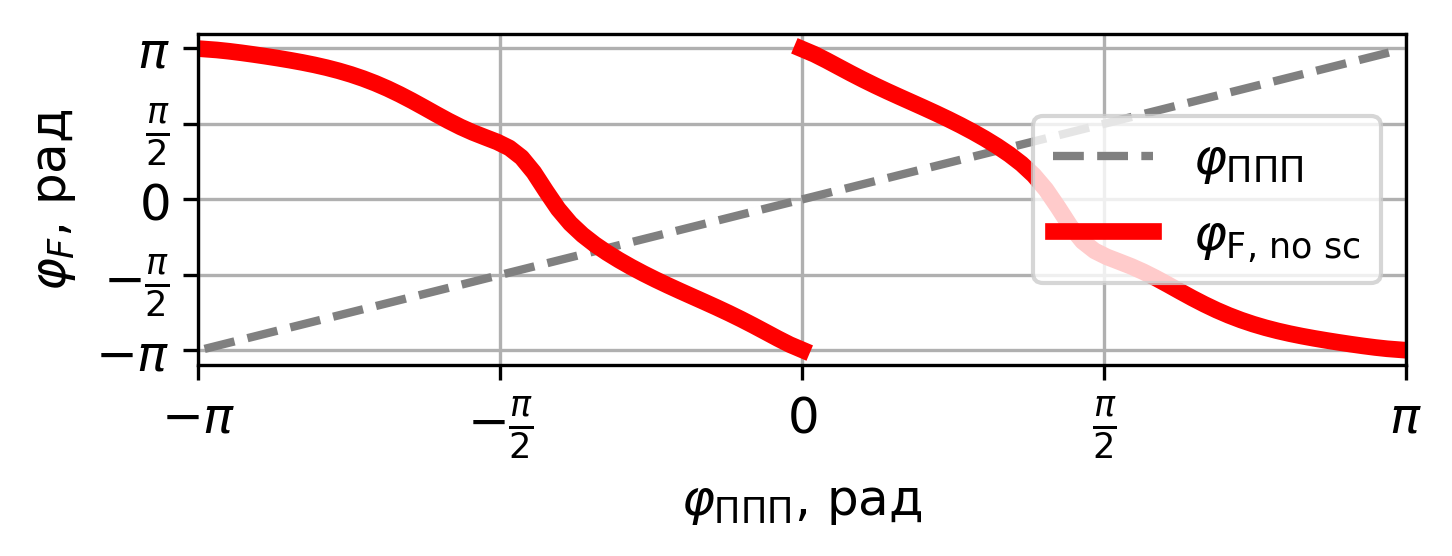

In [270]:
plt.figure(figsize=(5,2), dpi=300)
plt.plot(PHI_wrapped[:50], PHI_wrapped[:50], label=r'$\varphi_{\text{ППП}}$', lw=2, ls='--', c='gray')
plt.plot(PHI_wrapped[50:], PHI_wrapped[50:], lw=2, ls='--', c='gray')

plt.plot(PHI_wrapped[:50], np.arctan2( (F_y_smooth[:50,0]-F_y_smooth[:50,7]), (F_x_smooth[:50,0]-F_x_smooth[:50,1]-F_x_smooth[:50,4]-F_x_smooth[:50,7])), label=r'$\varphi_\text{F, no sc}$', lw=4, c='r')
plt.plot(PHI_wrapped[50:], np.arctan2((F_y_smooth[50:,0]-F_y_smooth[50:,7]),(F_x_smooth[50:,0]-F_x_smooth[50:,1]-F_x_smooth[50:,4]-F_x_smooth[50:,7])), lw=4, c='r')
plt.grid()
plt.legend()
y_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
y_ticklabels = [r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$']
plt.yticks(y_ticks,y_ticklabels)

plt.xticks(y_ticks,y_ticklabels)
plt.xlabel(r'$\varphi_{\text{ППП}}$, рад')
plt.ylabel(r'$\varphi_F$, рад')
plt.xlim(-np.pi,np.pi)
plt.tight_layout()
plt.savefig('phi_f_phi_spp_no_crest.pdf', dpi=300)

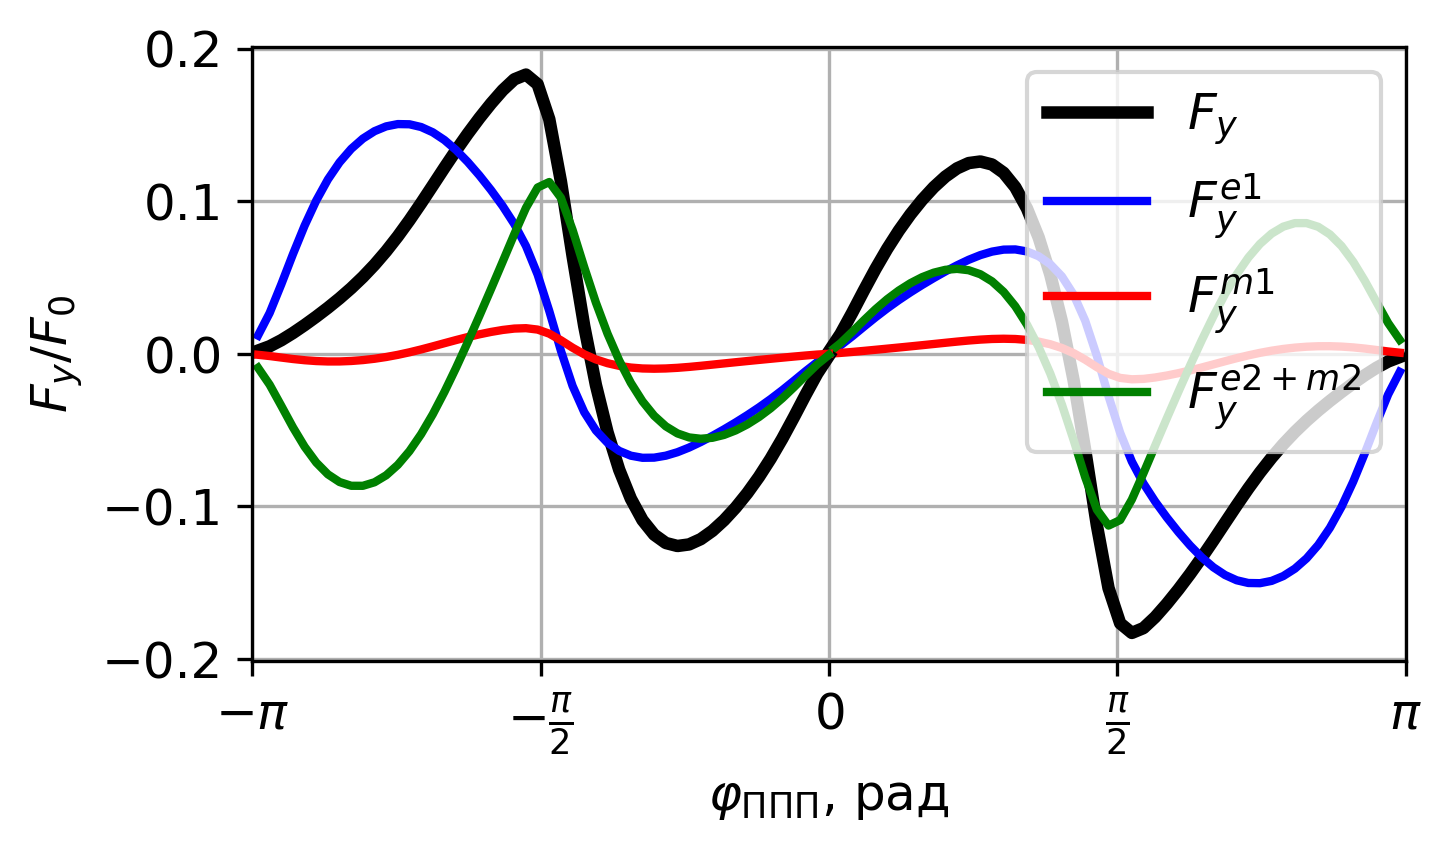

In [273]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(PHI_wrapped[:50], (F_y_smooth[:50,0]-F_y_smooth[:50,7])/fmax_wls, label='$F_y$', linewidth=3, c='black')
ax1.plot(PHI_wrapped[:50], F_y_smooth[:50,2]/fmax_wls, label='$F_y^{e1}$', linewidth=2, c='b')
ax1.plot(PHI_wrapped[:50], F_y_smooth[:50,5]/fmax_wls, label='$F_y^{m1}$', linewidth=2, c='r')
ax1.plot(PHI_wrapped[:50], (F_y_smooth[:50,6]+F_y_smooth[:50,3])/fmax_wls, label='$F_y^{e2+m2}$', linewidth=2, c='g')
#ax1.plot(PHI_wrapped[:50], (F_y_smooth[:50,7])/fmax_wls, label='$F_y^{\\times}$', linewidth=2, c='orange')

ax1.plot(PHI_wrapped[50:], (F_y_smooth[50:,0]-F_y_smooth[50:,7])/fmax_wls, linewidth=3, c='black')
ax1.plot(PHI_wrapped[50:], F_y_smooth[50:,2]/fmax_wls, linewidth=2, c='b')
ax1.plot(PHI_wrapped[50:], F_y_smooth[50:,5]/fmax_wls, linewidth=2, c='r')
ax1.plot(PHI_wrapped[50:], (F_y_smooth[50:,6]+F_y_smooth[50:,3])/fmax_wls, linewidth=2, c='g')
#ax1.plot(PHI_wrapped[50:], (F_y_smooth[50:,7])/fmax_wls, linewidth=2, c='orange')

ax1.grid(True)
ax1.legend(loc='best')
ax1.set_xlabel(r'$\varphi_{\text{ППП}}$, рад')
ax1.set_ylabel('$F_y/F_0$')
plt.xlim(-np.pi, np.pi)
plt.xticks(y_ticks,y_ticklabels)
plt.tight_layout()
plt.savefig('fy_comp_spp_dir_no_crest.pdf', dpi=300)
plt.show()


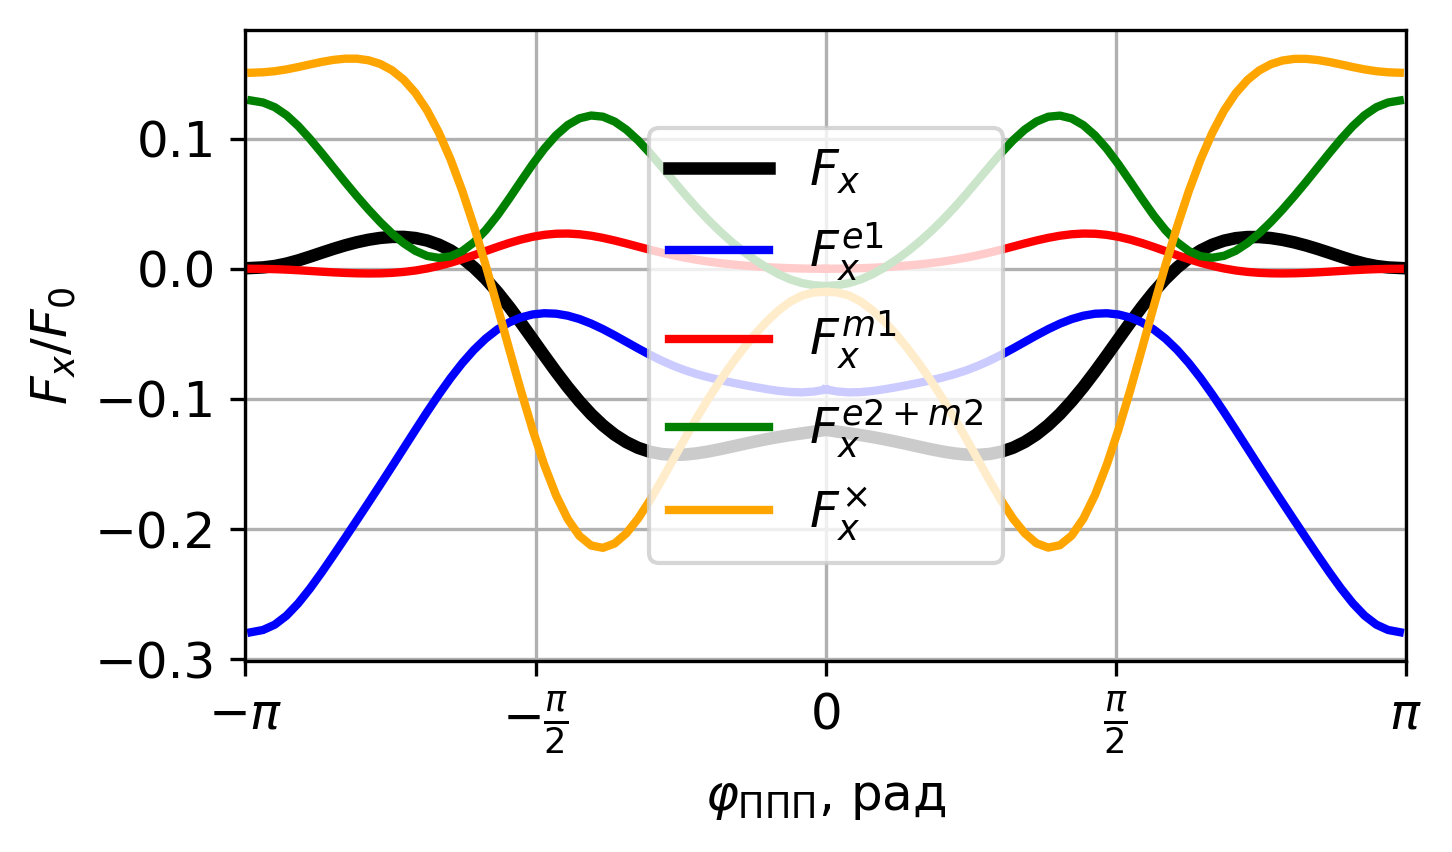

In [265]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(PHI_wrapped[:50], (F_x_smooth[:50,0]-F_x_smooth[:50,1]-F_x_smooth[:50,4])/fmax_wls, label='$F_x$', linewidth=3, c='black')
ax1.plot(PHI_wrapped[:50], F_x_smooth[:50,2]/fmax_wls, label='$F_x^{e1}$', linewidth=2, c='b')
ax1.plot(PHI_wrapped[:50], F_x_smooth[:50,5]/fmax_wls, label='$F_x^{m1}$', linewidth=2, c='r')
ax1.plot(PHI_wrapped[:50], (F_x_smooth[:50,6]+F_x_smooth[:50,3])/fmax_wls, label='$F_x^{e2+m2}$', linewidth=2, c='g')
ax1.plot(PHI_wrapped[:50], (F_x_smooth[:50,7])/fmax_wls, label='$F_x^{\\times}$', linewidth=2, c='orange')

ax1.plot(PHI_wrapped[50:], (F_x_smooth[50:,0]-F_x_smooth[50:,1]-F_x_smooth[50:,4])/fmax_wls, linewidth=3, c='black')
ax1.plot(PHI_wrapped[50:], F_x_smooth[50:,2]/fmax_wls, linewidth=2, c='b')
ax1.plot(PHI_wrapped[50:], F_x_smooth[50:,5]/fmax_wls, linewidth=2, c='r')
ax1.plot(PHI_wrapped[50:], (F_x_smooth[50:,6]+F_x_smooth[50:,3])/fmax_wls, linewidth=2, c='g')
ax1.plot(PHI_wrapped[50:], (F_x_smooth[50:,7])/fmax_wls, linewidth=2, c='orange')

ax1.grid(True)
ax1.legend(loc='center')
ax1.set_xlabel(r'$\varphi_{\text{ППП}}$, рад')
ax1.set_ylabel('$F_x/F_0$')
plt.xlim(-np.pi, np.pi)
plt.xticks(y_ticks,y_ticklabels)
plt.tight_layout()
plt.savefig('fx_comp_spp_dir.pdf', dpi=300)
plt.show()


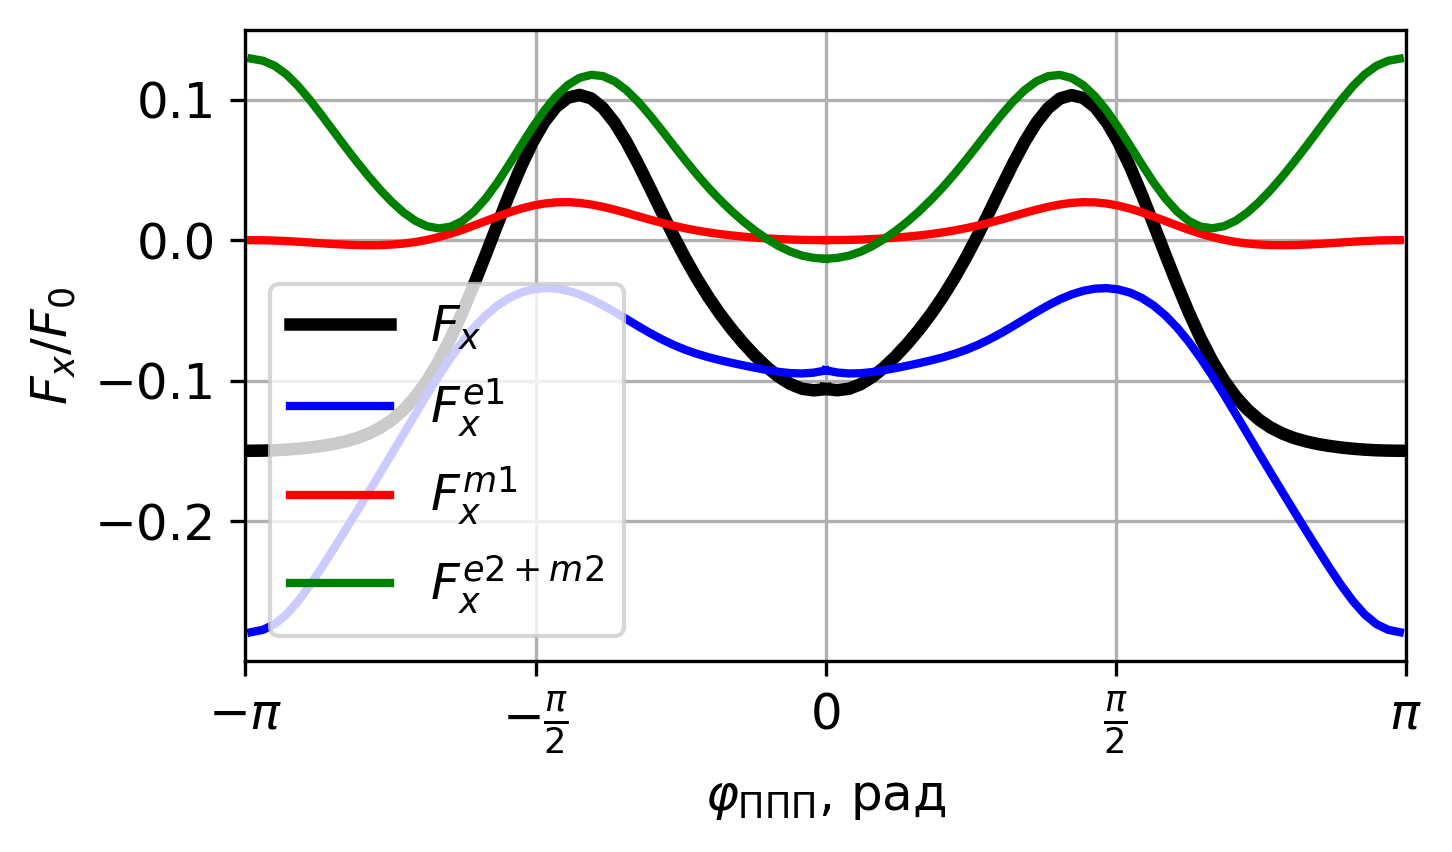

In [275]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(PHI_wrapped[:50], (F_x_smooth[:50,0]-F_x_smooth[:50,7]-F_x_smooth[:50,1]-F_x_smooth[:50,4])/fmax_wls, label='$F_x$', linewidth=3, c='black')
ax1.plot(PHI_wrapped[:50], F_x_smooth[:50,2]/fmax_wls, label='$F_x^{e1}$', linewidth=2, c='b')
ax1.plot(PHI_wrapped[:50], F_x_smooth[:50,5]/fmax_wls, label='$F_x^{m1}$', linewidth=2, c='r')
ax1.plot(PHI_wrapped[:50], (F_x_smooth[:50,6]+F_x_smooth[:50,3])/fmax_wls, label='$F_x^{e2+m2}$', linewidth=2, c='g')
#ax1.plot(PHI_wrapped[:50], (F_y_smooth[:50,7])/fmax_wls, label='$F_y^{\\times}$', linewidth=2, c='orange')

ax1.plot(PHI_wrapped[50:], (F_x_smooth[50:,0]-F_x_smooth[50:,7]-F_x_smooth[50:,1]-F_x_smooth[50:,4])/fmax_wls, linewidth=3, c='black')
ax1.plot(PHI_wrapped[50:], F_x_smooth[50:,2]/fmax_wls, linewidth=2, c='b')
ax1.plot(PHI_wrapped[50:], F_x_smooth[50:,5]/fmax_wls, linewidth=2, c='r')
ax1.plot(PHI_wrapped[50:], (F_x_smooth[50:,6]+F_x_smooth[50:,3])/fmax_wls, linewidth=2, c='g')
#ax1.plot(PHI_wrapped[50:], (F_y_smooth[50:,7])/fmax_wls, linewidth=2, c='orange')

ax1.grid(True)
ax1.legend(loc='best')
ax1.set_xlabel(r'$\varphi_{\text{ППП}}$, рад')
ax1.set_ylabel('$F_x/F_0$')
plt.xlim(-np.pi, np.pi)
plt.xticks(y_ticks,y_ticklabels)
plt.tight_layout()
plt.savefig('fx_comp_spp_dir_no_crest.pdf', dpi=300)
plt.show()

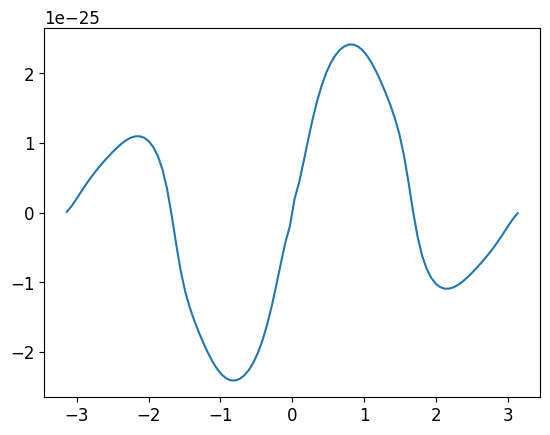

In [277]:
plt.plot(PHI, F_y_smooth[:,2])